# Hearthstone Project
***
***

# Goals
- Explore the data to gather insights about the unique and uncommon traits of the game's different class types

# Purpose
- Practice visualizing data using a variety of different plot types

# Setup
***

In [1]:
# establishing environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
import nltk
import math

from acquire import get_hearth
from prepare import prep_hearth
from math import pi
from matplotlib_venn import venn2, venn2_circles
from wordcloud import WordCloud
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import circlify
import warnings
warnings.filterwarnings("ignore")

# Acquire
Acquiring data from local csv files
***

In [2]:
# reading in card data and saving as DF
cards = pd.read_csv('hearthstone_standard_cards.csv')

# reading in card classes and saving as DF
classes = pd.read_csv('classes.csv')

# reading in minion types data and saving as DF
mtypes = pd.read_csv('minionTypes.csv')

# reading in types data and saving as DF
ctypes = pd.read_csv('types.csv')

# reading in keywords data and saving as DF
keywords = pd.read_csv('keywords.csv')

- Data acquired from local csv files
- Alternatively, the __get_hearth__ function from the __acquire.py__ file can be run to acquire the data
    - The DFs will be returned in the following order by the function: cards, classes, mtypes, ctypes, keywords

# Prepare
Preparing data for exploration


__IMPORTANT NOTE: Some preparations to the data will be done solely for the purpose of practicing preparation techniques and will not be relevant to the exploration phase.__
***

## Preparing DataFrames for Merge

### Lowercasing column names and values
### Dropping unneeded columns and changing various column names

In [3]:
# lowercasing cards DF columns
cards.columns = cards.columns.str.lower()

# lowercasing name and text column values
cards.text = cards.text.str.lower()
cards.name = cards.name.str.lower()

# creating list of all DFs besides cards
df_list = [classes, mtypes, ctypes, keywords]

# iterating through DFs
# lowercasing all column names, dropping original name column, renaming slug to name column
for dtafrm in df_list:
        dtafrm.columns = dtafrm.columns.str.lower()
        dtafrm.drop(columns = 'name', inplace = True)
        dtafrm.rename(columns = {"slug": "name"}, inplace = True)       

## Merging DataFrames

### Merging 'classes' DF

In [4]:
# removing brackets and commas from multiclassids column
cards.multiclassids = cards.multiclassids.str.replace('\]|,|\[' , '')

# creating column to hold primary class id 
# if card is of one class, this will reflect its sole class
# if card is dual, this will reflect the 1st of the two classes in the multiClassIds column
# necessary since dual class cards erroneously hold the 'neutral' class value in their primary class id 
cards['primeclassid'] = np.where((cards.multiclassids.str.contains(' ')), cards["multiclassids"].str.split(" ", expand = True)[0], cards.classid)

# converting key columns to make all value data types match
cards.primeclassid = cards.primeclassid.astype(str)
classes.id = classes.id.astype(str)

# merging 'classes' df with card df
df = pd.merge(cards, classes[['id', 'name']], 
              left_on = 'primeclassid', right_on = 'id', how="left", 
              suffixes = (None, '_prime_hero_class'))

# dropping columns I no longer need
df.drop(columns = ['primeclassid', 'classid', 'duels'], inplace = True)

### Merging 'mtypes' DF

In [5]:
# changing null values of minionTypeId for neutral minions to -1
df['miniontypeid'] = np.where((df.miniontypeid.isnull() == True) & (df.cardtypeid == 4), -1, df.miniontypeid)

# adding missing keyword data to 'keywords' df
# -1 is for minions with no tribe
mtypes.loc[len(mtypes.index)] = ['no_tribe', -1]

# merging 'mtypes' df
df = pd.merge(df, mtypes[['id', 'name']], 
              left_on = 'miniontypeid', right_on = 'id', how="left", 
              suffixes = (None, '_minion_type'))

# dropping column I no longer need
df.drop(columns = ['miniontypeid'], inplace = True)

### Merging 'ctypes' DF

In [6]:
# merging 'ctypes' df
df = pd.merge(df, ctypes[['id', 'name']], 
              left_on = 'cardtypeid', right_on = 'id', how="left", 
              suffixes = (None, '_card_type'))

# dropping column I no longer need
df.drop(columns = ['cardtypeid'], inplace = True)

### Merging 'keywords' DF

In [7]:
# replacing dashes with underscores in names
keywords.name = keywords.name.str.replace('-', '_')

# adding missing keyword data to 'keywords' df
keywords.loc[len(keywords.index)] = ['64', 'start_of_game', 
                                     'does something at the start of the game.', 
                                     'does something at the start of the game.']

# removing brackets and commas from keyword id column
df.keywordids = df.keywordids.str.replace('\]|,|\[' , '')

# splitting keyword ids into separate columns for each card
kwdf = df["keywordids"].str.split(" ", expand = True) 

# renaming columns
kwdf.columns = ['keywordid1', 'keywordid2', 'keywordid3', 'keywordid4', 'keywordid5']

# concatenating split keyword id columns with main df
df = pd.concat([df, kwdf], axis=1)

# converting keywords id column to str type to enable merge
keywords.id = keywords.id.astype(str)

# creating loop to add a column for the text name of each keyword ability of each card
# via merging with keywords DF
for x in kwdf.columns:
    df = pd.merge(df, keywords[['id', 'name']], 
              left_on = x, right_on = 'id', how = "left",
              suffixes = (None, x + '_name'))

## Checking for duplicate rows

In [8]:
# checking number of rows in current DF
df.shape

(1289, 41)

In [9]:
# Checking number of rows if duplicates were dropped
df.drop_duplicates().shape

(1289, 41)

- No duplicates found

### Checking for proper data types, categorical columns (based on domain knowledge), and null counts

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1289 entries, 0 to 1288
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1289 non-null   int64  
 1   collectible            1289 non-null   int64  
 2   slug                   1289 non-null   object 
 3   multiclassids          1289 non-null   object 
 4   cardsetid              1289 non-null   int64  
 5   rarityid               1289 non-null   int64  
 6   artistname             1288 non-null   object 
 7   manacost               1289 non-null   int64  
 8   name                   1289 non-null   object 
 9   text                   1271 non-null   object 
 10  image                  1289 non-null   object 
 11  imagegold              805 non-null    object 
 12  flavortext             1289 non-null   object 
 13  cropimage              1289 non-null   object 
 14  health                 825 non-null    float64
 15  atta

- The following columns will be dropped as they won't be needed for the expected operations of this project
    - id, slug
        - unique identifiers for cards, not needed since the 'name' column provides this while also being easier to reference
    - artistname, cardsetid, duels
        -  I don't anticipate that the names of the cards' artists, their set names, or their existence in the duels format will confer any insight about the characteristics of their respective hero classes
    - image, imagegold, cropimage
        - I won't be exploring the images of the cards in this iteration of the project but I may in the future
    - collectible
        - Only 1 value, no nulls, doesn't distinguish any cards
    - all columns reflecting key words with the exception of the boolean columns and the 'slug_keyword#_name' columns
        - The exempted columns are sufficient for the project's expected operations
     
     
- Based on my domain knowledge of the game, I'm inferring that several of the columns are categorical
    - I need to create boolean columns for categorical columns (rarity, card set, etc.)


- Many null values that need to be addressed
    - text
    - duels
    - minion type id
    - health
    - attack
    - child ids
    - durability
    - armor

### Dropping columns that aren't needed for the planned operations of this project

In [11]:
# creating list of columns to drop
columns_to_drop = ['id', 'slug', 'artistname', 'image', 'imagegold', 'flavortext', 'cropimage', 'collectible']

# dropping columns
df.drop(columns = columns_to_drop, inplace = True)

## Addressing Null Values

### Addressing nulls in 'text' column

In [12]:
# checking values in text box
df.text.value_counts(dropna = False)

NaN                                                           18
<b>taunt</b>                                                  15
<b>charge</b>                                                  7
<b>spell damage +1</b>                                         6
<b>stealth</b>                                                 6
                                                              ..
<b>twinspell</b> give a friendly minion <b>lifesteal</b>.      1
gain 2 mana crystals this turn only. <b>overload:</b> (2)      1
after you play a <b>secret</b>, <b>discover</b> a spell.       1
<b>battlecry:</b> give a random minion in your hand +1/+1.     1
summon two 0/2 minions with <b>taunt</b>.                      1
Name: text, Length: 1215, dtype: int64

In [13]:
# filling null text values with 'no effect'
df["text"].fillna("no effect", inplace = True) 

### Addressing nulls in 'id_minion_type', and 'slug_minion_type' columns

In [14]:
# checking minontypeId values
df.id_minion_type.value_counts(dropna = False)

-1.0     497
 NaN     471
 20.0     75
 15.0     63
 18.0     51
 24.0     50
 17.0     32
 14.0     25
 23.0     18
 21.0      6
 26.0      1
Name: id_minion_type, dtype: int64

In [15]:
# converting nulls, aka non-minion cards to 'not a minion' type
df['id_minion_tribe'] = np.where((df.id_minion_type.isnull() == True), 'not a minion', df.id_minion_type)
df['name_minion_tribe'] = np.where((df.name_minion_type.isnull() == True), 'not a minion', df.name_minion_type)

# dropping minionTypeId since id_minion_type suffices
df.drop(columns = ['id_minion_type', 'name_minion_type'], inplace = True)

### Addressing nulls in 'childIds' column

In [16]:
# checking childIds values
df.childids.value_counts(dropna = False)

NaN                                                                       994
[52897, 52900, 53160, 53161, 53162, 53163, 55378, 60588, 64652, 64653]     15
[59723]                                                                     8
[53921]                                                                     3
[56927]                                                                     3
                                                                         ... 
[57702]                                                                     1
[55244]                                                                     1
[62039]                                                                     1
[54488]                                                                     1
[53577, 53578, 53579]                                                       1
Name: childids, Length: 261, dtype: int64

In [17]:
# filling nulls with "no_childid"
df.childids.fillna("no_childid", inplace = True) 

### Addressing nulls in 'health' and 'attack' columns
These variable's respective columns have null values since neither of them apply to every card (examples: minions have health but spells and weapons do not). For the time being I'll fill these nulls 
with a value that represents infinity since doing so allows me to preserve the int64 data type of the column. Furthermore, no matter what value the developer assigns to these variables in future cards, this value probably won't be used. If this causes issues later I'll employ a different means of handling them. 

In [18]:
# creating list of column names
hada = ['health', 'attack', 'durability', 'armor']

# iterating through columns filling nulls within each
for att in hada:
    df[att].fillna(float('inf'), inplace = True)

## Creating boolean columns for categorical variables

### Creating boolean columns for 'keywords'

In [19]:
# loop iterates through each keyword and creates a boolean column for it
for kw in keywords.name:
    df['has_' + kw] = np.where(
    (df.namekeywordid1_name == kw) |
    (df.namekeywordid2_name == kw) |
    (df.namekeywordid3_name == kw) |
    (df.namekeywordid4_name == kw) |
    (df.namekeywordid5_name == kw), 1, 0)

# filling nulls in temporary columns with spaces to allow concatenation in next section
df.namekeywordid1_name.fillna(' ', inplace = True)
df.namekeywordid2_name.fillna(' ', inplace = True)
df.namekeywordid3_name.fillna(' ', inplace = True)
df.namekeywordid4_name.fillna(' ', inplace = True)
df.namekeywordid5_name.fillna(' ', inplace = True)
    
# creating column that holds all keyword names for each card
df['allkws'] = df.namekeywordid1_name + ' ' + df.namekeywordid2_name + ' ' + df.namekeywordid3_name + ' ' + df.namekeywordid4_name + ' ' + df.namekeywordid5_name

# creating empty list
key_word_col_drop = []

# iterating through columns in df and creating list of columns to drop
for col in df.columns:
    if 'keywordid' in col:
        key_word_col_drop.append(col)
        
# dropping columns
df.drop(columns = key_word_col_drop, inplace = True)

### Creating boolean columns for 'hero classes'

In [20]:
# removing brackets and commas from multiclassids column
df.multiclassids = df.multiclassids.str.replace('\]|,|\[' , '')

# creating column that holds secondary class separate from primary class
df['id_second_hero_class'] = df["multiclassids"].str.split(" ", expand = True)[1]

# converting column to str type to enable merge with newly created column 'id_second_hero_class'
classes.id = classes.id.astype(str)

# creating df containing columns for merge in order to rename before merge without altering original classes DF
classes2 = classes[['id', 'name']]

# renaming columns
classes2.columns = ['id_second_hero_class', 'name_second_hero_class']

# merging 'classes' on secondary hero class id to get secondary class names
df = pd.merge(df, classes2[['id_second_hero_class', 'name_second_hero_class']], 
              on = 'id_second_hero_class', how = "left")

# creating boolean columns for each hero class
for c in classes.name:
    df['is_' + c] = np.where(
    (df.name_prime_hero_class == c) | (df.name_second_hero_class == c), 1, 0)

# filling nulls in new columns
df['name_second_hero_class'].fillna('monoclass', inplace = True)
df['id_second_hero_class'].fillna('monoclass', inplace = True)

### Creating boolean column for multiclass cards

In [21]:
# creating column where 1 = multiclass, 0 = monoclass)
# contains ' ' will suffice since only cards with a space in this value are multiclass
df['is_multiclass'] = np.where((df.multiclassids.str.contains(' ')), 1, 0)

# dropping column I no longer need
df.drop(columns = 'multiclassids', inplace = True)

### Creating boolean column for cards with child ids

In [22]:
# creating column where 1 = card has childids, 0 = card has no childids)
# contains ',' will suffice since only cards with a comma in this value have childids
df['has_child_ids'] = np.where((df.childids.str.contains(',')), 1, 0)

### Creating boolean columns for card type

In [23]:
# iterating through card types and creating a boolean column for each
for ctype in ctypes.name:
    df['is_' + ctype] = np.where((df.name_card_type == ctype), 1, 0)

# dropping column I no longer need
df.drop(columns = 'id_card_type', inplace = True)

### Creating boolean columns for minion tribe

In [24]:
# iterating through minion tribes and creating a boolean column for each
for mtype in mtypes.name:
    df['is_' + mtype] = np.where((df.name_minion_tribe == mtype), 1, 0)

# dropping column I no longer need
df.drop(columns = 'id_minion_tribe', inplace = True)

## Other Preparations

### Dropping boolean columns with all 0 values
I know that some of the keywords that were turned into booleans are not currently in standard (the format the collection of the cards in the data are part of). These columns will be completely filled with 0s so I'm going to drop them.

In [25]:
# creating list of index values for columns that only have 0 values
all_0_cols = np.where(df.isin([0]).all() == True)

# dropping columns based on index value
df.drop(df.columns[all_0_cols], axis = 1, inplace = True)

### Adding rows for dual class cards with prime and secondary class swapped
Adding these rows will make it easier to perform certain operations such as grouping and plotting.

In [26]:
# making identical dfs of all dual class cards
dcc = df[df.name_second_hero_class != 'monoclass']
dcc2 = df[df.name_second_hero_class != 'monoclass']

# swapping primary and secondary hero class values
dcc2.name_prime_hero_class, dcc2.name_second_hero_class, dcc2.id_prime_hero_class, dcc2.id_second_hero_class = dcc.name_second_hero_class, dcc.name_prime_hero_class, dcc.id_second_hero_class, dcc.id_prime_hero_class

# adding new rows to main df
df = pd.concat([df, dcc2])

# resetting index
df.reset_index(drop = True, inplace = True)

### Adding column that holds count of words in card name

In [27]:
# counting words in card names and adding as variable
df['name_word_count'] = df.name.apply(lambda x: len(str(x).split(' ')))

### Adding column that holds count of childids

In [28]:
# counting number of chilids and adding as variable
df['childid_count'] = np.where((df.childids != 'no_childid'), df['childids'].str.split().str.len(), 0)

### Updating erroneous weapon attack values
While exploring, I found cards that had inf values (since they began as null) that were incorrect 

In [29]:
# identifying index values
df[(df.attack == np.inf) & (df.is_weapon == True)]

,cardsetid,rarityid,manacost,name,text,health,attack,childids,durability,armor,...,is_mech,is_elemental,is_beast,is_totem,is_pirate,is_dragon,is_all,is_no_tribe,name_word_count,childid_count
806,1466,1,1,spiked wheel,has +3 attack while your hero has armor.,inf,inf,no_childid,2.0,inf,...,0,0,0,0,0,0,0,0,2,0
921,1443,5,1,sphere of sapience,"at the start of your turn, look at your top ca...",inf,inf,[62233],4.0,inf,...,0,0,0,0,0,0,0,0,3,1


In [30]:
# updating attack values to correct values
df.at[806,'attack'] = 3
df.at[921,'attack'] = 0

### Adjusting column order

In [31]:
# adjusting order of columns
df = df[['manacost', 'name', 'name_word_count', 'text', 'has_child_ids', 'childids', 'childid_count', 'health', 'attack',
       'durability', 'id_prime_hero_class', 'name_prime_hero_class', 
       'id_second_hero_class', 'name_second_hero_class', 'allkws', 'name_card_type',
       'name_minion_tribe', 'has_taunt', 'has_spellpower', 'has_divine_shield',
       'has_charge', 'has_secret', 'has_stealth', 'has_battlecry',
       'has_freeze', 'has_windfury', 'has_deathrattle', 'has_combo',
       'has_overload', 'has_silence', 'has_counter', 'has_immune',
       'has_discover', 'has_quest', 'has_poisonous', 'has_lifesteal',
       'has_rush', 'has_evilzug', 'has_twinspell', 'has_mega_windfury',
       'has_reborn', 'has_empower', 'has_outcast', 'has_spellburst',
       'has_sidequest', 'has_corrupt', 'has_start_of_game',
       'is_demonhunter', 'is_druid', 'is_hunter', 'is_mage', 'is_paladin', 'is_priest',
       'is_rogue', 'is_shaman', 'is_warlock', 'is_warrior', 'is_neutral',
       'is_multiclass','is_hero', 'is_minion', 'is_spell',
       'is_weapon', 'is_murloc', 'is_demon', 'is_mech', 'is_elemental',
       'is_beast', 'is_totem', 'is_pirate', 'is_dragon', 'is_all',
       'is_no_tribe']]

# Preparation Phase Summary
- Lowercased all column names and values

- Merged all dataFrames into single dataframe

- Added missing keyword value (start of game)

- Added rows for dual class cards with primary and secondary hero class values swapped

- Changed all dashes in column names to underscores

- Checked for duplicate rows, none found

- Filled nulls with different values based on column and intended operations

- Created boolean columns for categorical values

- Dropped columns that were unuseful for the operations of this project

- Reordered columns

- Alternatively, the __prep_hearth__ function from the __prepare.py__ file can be run (with the 5 separate DFs made from the local csv files as arguments) to prep the data.

In [32]:
# Uncomment lines below and run to acquire and prep data without needing to run code above (besides imports)

#cards, classes, mtypes, ctypes, keywords = get_hearth()
#df = prep_hearth(cards, classes, mtypes, ctypes, keywords)


# Explore
Exploring the data to identify the characteristics of each class, including neutral

### Creating dictionary of colors, list of colors, and color mapper function for plots

In [33]:
# creating dictionary that holds each class as a key with a color
# can be used to specify the color in plots where a dictionary is accepting for mapping colors to values
colord = {'Rogue' : 'gray', 'Shaman' : 'aqua', 'Hunter' : 'lime', 'Warrior' : 'red', 'Priest' : 'white', 
          'Paladin' : 'gold', 'Mage' : 'cornflowerblue', 'Warlock' : 'mediumorchid', 'Demonhunter' : 'green',
          'Druid' : 'saddlebrown', 'Neutral' : 'pink'}

# sorting colorsby corresponding class hero in alphabetical order
sorted_color_df = pd.DataFrame.from_dict(colord, orient='index').sort_index()
# creating list of colors in DF above
sorted_colors = [i for x in sorted_color_df.values for i in x]

# function accepts list of of hero classes and returns sorted list of colors for plotting
# useful when one of the items above can't be applied (ie. customer sorting of hero classes)
def color_mapper(hero_class_list):
    color_list = []
    for x in hero_class_list:
        color_list.append(colord[x])
    return color_list

### Setting plot figure sizes when size is not specified otherwise

In [34]:
plt.rcParams["figure.figsize"] = (12,8)

### Creating separate DFs for each major card type

In [35]:
minions = df[df.is_minion == 1]
heros = df[df.is_hero == 1]
spells = df[df.is_spell == 1]
weapons = df[df.is_weapon== 1]

### Creating list of class names

In [36]:
classnames = classes.name.to_list()

## Percentage of Minions and Spells within each Class
Since weapons and hero cards make up only a small minority (if any) of the cards within each class, I'm not going to include them in the visualization below.
#### NOTE: I'm aware pie charts are commonly considered bad practice. Since this is a personal projet, I'm making this simply for exhibition purposes.

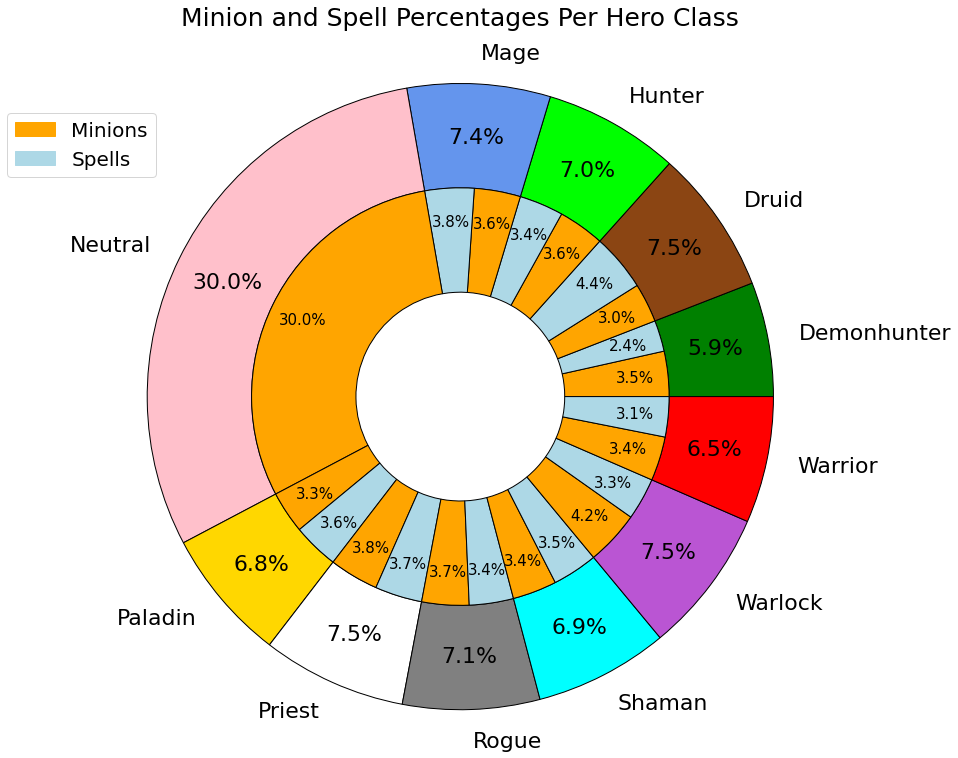

In [37]:
# creating df with all cards except hero cards and weapons
donutplotdf = df[(df.name_card_type != 'hero') & ((df.name_card_type != 'weapon'))]

# creating df of card counts for each hero class
hero_dist_df = pd.DataFrame(donutplotdf.name_prime_hero_class.value_counts().sort_index())
hero_dist_df.columns = ['hero_class_card_count']

# creating df of card counts per card type per hero class
card_type_dist_df = pd.DataFrame(donutplotdf.groupby(['name_prime_hero_class', 'name_card_type']).count()['name'].sort_index(level=['name_prime_hero_class']))

# setting values for outer ring
major_pie_groups = [classname.title() for classname in hero_dist_df.index]
major_group_sizes = [percent for percent in hero_dist_df.hero_class_card_count]

# setting values for inner ring
minor_pie_groups = [x[1] for x in card_type_dist_df.to_dict()['name'].keys()]
minor_group_sizes = [cardtypecount for numlist in card_type_dist_df.values.tolist() for cardtypecount in numlist]

# creating list for minion and spell colors
min_and_spell_colors = [word.replace('minion' ,'orange') for word in minor_pie_groups]
min_and_spell_colors = [word.replace('spell','lightblue') for word in min_and_spell_colors]

# creating outside ring
fig, ax = plt.subplots(figsize=(12,12))
ax.axis('equal')
mypie, _, autotexts = ax.pie(major_group_sizes, radius=1.2, labels = major_pie_groups, autopct='%1.1f%%', pctdistance= .83, colors = sorted_colors, textprops={'fontsize': 22})
plt.setp(mypie, width=0.4, edgecolor='black')

# creating inner ring
mypie2, _, autotexts2 = ax.pie(minor_group_sizes, radius=1.2-0.4, autopct='%1.1f%%', pctdistance= .84, colors = min_and_spell_colors, textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='black')
plt.margins(0,0)

# creating color list for inner circle
minion_legend_item = mpatches.Patch(color='orange', label='Minions')
spell_legend_item  = mpatches.Patch(color='lightblue', label='Spells')

# creating custom legend
leg = plt.legend(handles=[minion_legend_item, spell_legend_item], prop={"size":20}, bbox_to_anchor=(0.06, .95))

# adding title to plot
plt.title('Minion and Spell Percentages Per Hero Class', fontsize = 25, pad = 45)

# displaying plot 
plt.show()

- The purpose of this visualization was to give an idea of about how the distribution of card types within each class (for example, do mages have a lot more spells than minions? do hunters have mostly minions?, etc)
    - Since I alread know that weapons and hero cards make up only a small minority of all cards, I removed them from the data used in the visualization above since their "slices" within the plot would be too small to offer meaningful insight beyond that they are the minority card types


- Neutral minions account for nearly 1/3 of all cards


- There are no neutral spell cards


- The combined amount of spells and minions within each non-neutral class are relatively close
    - Druid, Priest, and Warlock are tied for the majority at 7.5%
    - Demon Hunter has the lowest amount, making up 5.9% of all minions and spells
  
  
- Compared to other classes, Warlocks and Druids have notably more spells than minions


- Compared to other classes, Demonhunter have notably more minions than spells


- All other non-neutral hero classes possess more even ratios of spells to minions

## Average Mana Costs Per Class
Mana is a resource that players can spend on their turn to play cards. Generally speaking, the higher a cards' mana cost, the more powerful it is.

In [38]:
# creating df of average mana costs per class
avgmana = pd.DataFrame(df.groupby(['name_prime_hero_class']).mean().sort_values(by = 'manacost', ascending = True)['manacost'])
avgmana.index = avgmana.index.str.title()
avgmana

,manacost
name_prime_hero_class,
Rogue,3.051546
Shaman,3.360825
Hunter,3.385417
Warrior,3.402062
Priest,3.484536
Paladin,3.510417
Mage,3.614583
Warlock,3.680412
Demonhunter,3.698795


In [39]:
# creating df of average mana costs per class
avgmana = pd.DataFrame(df.groupby(['name_prime_hero_class']).mean().sort_values(by = 'manacost', ascending = True)['manacost'])
avgmana.index = avgmana.index.str.title()
avgmana

,manacost
name_prime_hero_class,
Rogue,3.051546
Shaman,3.360825
Hunter,3.385417
Warrior,3.402062
Priest,3.484536
Paladin,3.510417
Mage,3.614583
Warlock,3.680412
Demonhunter,3.698795


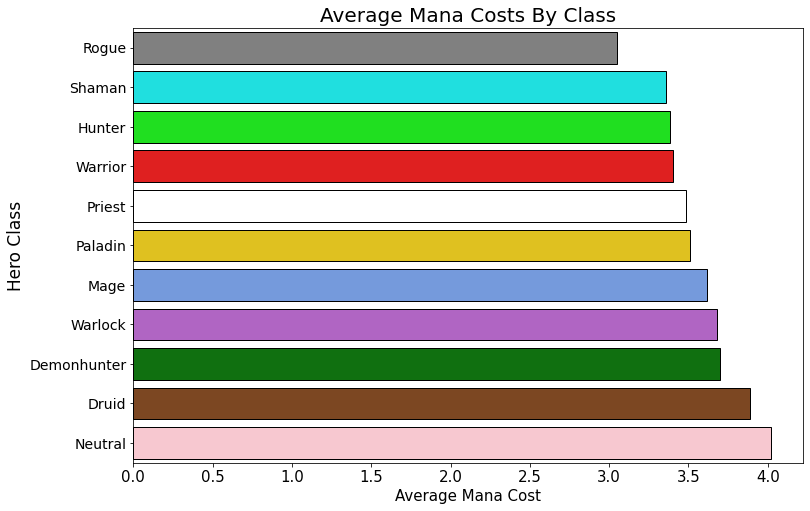

In [40]:
# creating plot
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 14)
plt.title("Average Mana Costs By Class", fontsize = 20)
ax = sns.barplot(x = "manacost", y = avgmana.index, data = avgmana, palette = colord, edgecolor = 'black')
ax.set_xlabel('Average Mana Cost', fontsize = 15)
ax.set_ylabel('Hero Class', fontsize = 17)
plt.show()

- Average mana costs range from ~3 to ~4 mana
    - Although this range may seem small, 1 mana is considered a significant difference in the viability of a card
- Rogue does has the lowest average mana cost, ~3
- Neutral has the highest average mana cost, ~4
- Of all non-neutral classes, Druid has the highest average mana cost, ~3.9

## Average Mana Costs for Each Class (Per Card Type) 

In [41]:
pd.DataFrame(df.groupby(['name_prime_hero_class', 'name_card_type']).mean()['manacost'])

manacost
name_prime_hero_class name_card_type           
demonhunter           minion           4.133333
                      spell            3.064516
                      weapon           3.714286
druid                 minion           4.948718
                      spell            3.157895
hunter                minion           3.934783
                      spell            2.795455
                      weapon           3.500000
mage                  hero            10.000000
                      minion           3.804348
                      spell            3.306122
neutral               minion           4.028497
                      weapon           1.000000
paladin               minion           4.023810
                      spell            3.021739
                      weapon           3.625000
priest                hero             7.000000
                      minion           3.918367
                      spell            2.957447
rogue                 hero             7.000000
                      minion           3.531915
                      spell            2.386364
                      weapon           3.600000
shaman                hero             7.000000
                      minion           3.954545
                      spell            2.666667
                      weapon           3.571429
warlock               hero             7.000000
                      minion           4.370370
                      spell            2.714286
warrior               hero             7.000000
                      minion           4.136364
                      spell            2.525000
                      weapon           3.333333

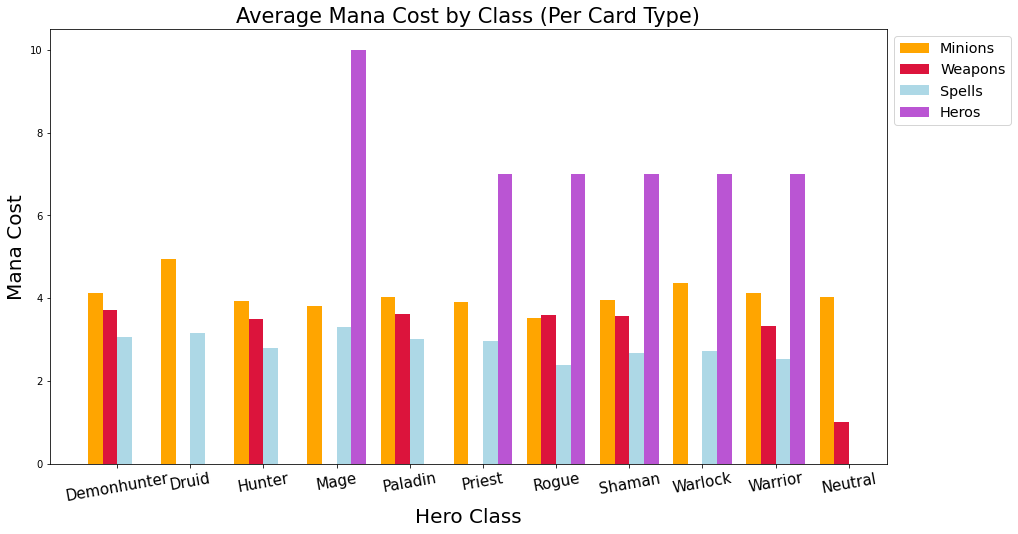

In [42]:
# creating empty dictionaries
minion_mc_dict = {}
weapon_mc_dict = {}
spell_mc_dict = {}
hero_mc_dict = {}

# iterating through class names and storing average manacost for each type of card within each class
for classname in classnames:
    minion_mc = minions[minions.name_prime_hero_class == classname].manacost.mean()
    weapon_mc = weapons[weapons.name_prime_hero_class == classname].manacost.mean()
    spell_mc = spells[spells.name_prime_hero_class == classname].manacost.mean()
    hero_mc = heros[heros.name_prime_hero_class == classname].manacost.mean()
    
    # adding values to dictionary for use in plot
    minion_mc_dict[classname] = minion_mc
    weapon_mc_dict[classname] = weapon_mc
    spell_mc_dict[classname] = spell_mc
    hero_mc_dict[classname] = hero_mc
    
x = np.arange(len(classnames))
width = 0.2 

# creating plots
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(x - width * 1.5, minion_mc_dict.values(), width, label= 'Minions', color = 'orange')
ax.bar(x - width * .5, weapon_mc_dict.values(), width, label = 'Weapons', color = 'crimson')
ax.bar(x + width * .5, spell_mc_dict.values(), width, label= 'Spells', color = 'lightblue')
ax.bar(x + width * 1.5, hero_mc_dict.values(), width, label = 'Heros', color = 'mediumorchid')

# setting x labels, y labels, xticks, etc.
ax.set_xlabel('Hero Class', fontsize = 20)
ax.set_ylabel('Mana Cost', fontsize = 20)
ax.set_title('Average Mana Cost by Class (Per Card Type)', fontsize = 21)
ax.set_xticks(x)
ax.set_xticklabels([classname.title() for classname in classnames], fontsize = 15, rotation = 10)
ax.legend(bbox_to_anchor=(1, 1), fontsize='x-large')
plt.show()

__General__
- Any bars that are missing from a class means that the class does not have any of that particular type of card
    - For example, mages don't have weapons currently
   
   
__Minions__    
- Druids have the more costly creatures
    - It makes sense that they have more expensive creatures since part of their identity is ramping up resources to play big creatures (and spells)
- Rogues have the cheapest creatures
    - This also makes sense given that part of their identity is being a fast-paced class that plays lots of inexpensive cards


__Weapons__
- The average cost of weapons for each class that has them is very similar with the exception of neutral which has much cheaper weapons


__Spells__
- The range of costs among spells is ~4 - ~5 mana
    - Rogues, have the cheapest spells
        - This is not surprising since again, they are known for have lots of small effect, cheap cards
    - Mages have the most expensive spells
        - This makes sense given that as the name would imply, mages focus on magic and part of their identity is having big, impactful spells, even more so than druid    
        
        
__Heros__
- No hero class has more than 1 hero card and some have non
- Furthermore, every hero class except for Mage share the same hero card, Galakrond, which explains why several have the same mana cost
       

## Average Word Counts in Name per Class

In [43]:
# creating df of average number of words in name per class 
avgnamewc = pd.DataFrame(df.groupby(['name_prime_hero_class']).mean().sort_values(by = 'name_word_count', ascending = True)['name_word_count'])
avgnamewc.index = avgnamewc.index.str.title()
avgnamewc

,name_word_count
name_prime_hero_class,
Rogue,1.845361
Warrior,1.896907
Shaman,1.907216
Hunter,1.947917
Demonhunter,1.963855
Neutral,1.966408
Warlock,1.979381
Druid,2.020833
Mage,2.072917


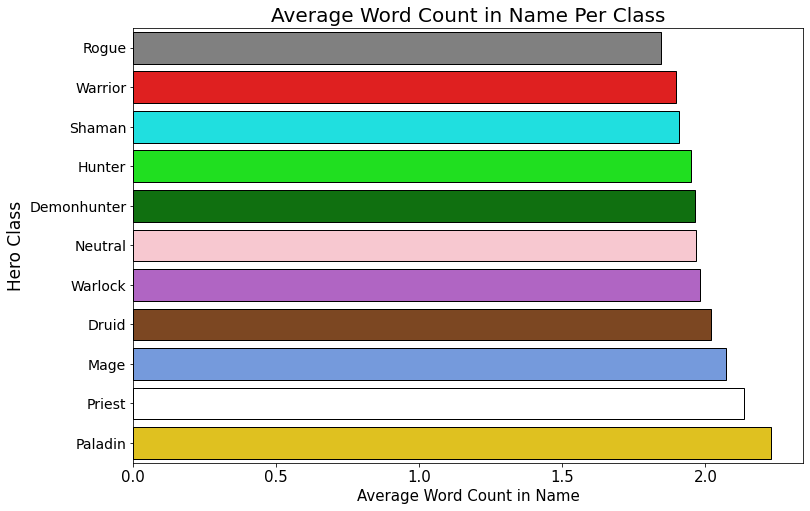

In [44]:
# creating plot
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 14)
plt.title("Average Word Count in Name Per Class", fontsize = 20)
ax = sns.barplot(x = "name_word_count", y = avgnamewc.index, data = avgnamewc, palette = colord, edgecolor = 'black')
ax.set_xlabel('Average Word Count in Name', fontsize = 15)
ax.set_ylabel('Hero Class', fontsize = 17)
plt.show()

- Very little variation in the word counts in the name's of each classes' cards
    - Range is ~1.8 to ~2.3 words
- Rogues have the lowest average words counts
- Paladins have the highest average word counts

## Average Name Word Count by Class (per Card Type)

In [45]:
df.groupby(['name_prime_hero_class', 'name_card_type']).mean()['name_word_count']

name_prime_hero_class  name_card_type
demonhunter            minion            2.000000
                       spell             1.967742
                       weapon            1.714286
druid                  minion            2.076923
                       spell             1.982456
hunter                 minion            1.847826
                       spell             2.068182
                       weapon            1.833333
mage                   hero              3.000000
                       minion            2.086957
                       spell             2.040816
neutral                minion            1.963731
                       weapon            3.000000
paladin                minion            2.142857
                       spell             2.239130
                       weapon            2.625000
priest                 hero              3.000000
                       minion            2.163265
                       spell             2.085106
rogue       

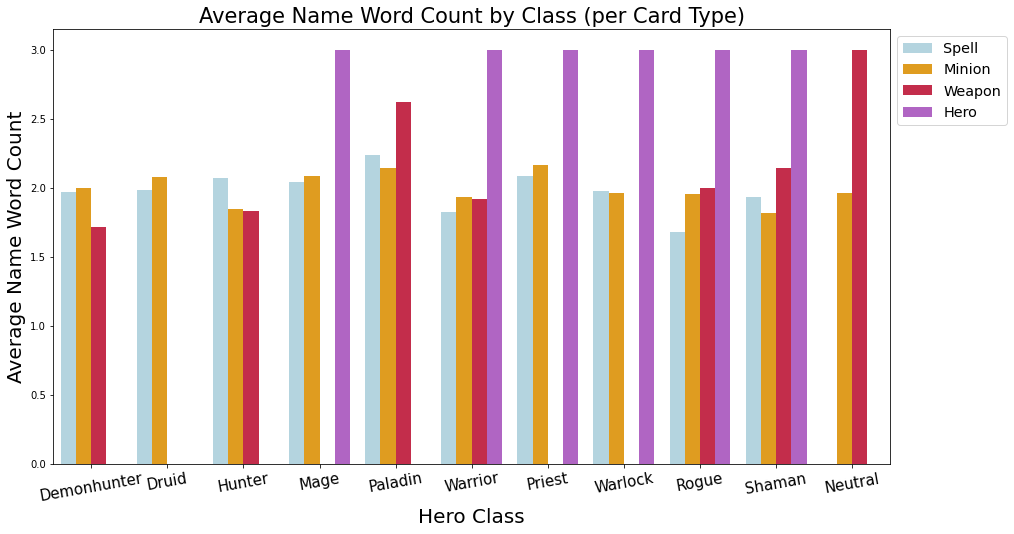

In [46]:
# creating dictionary for colors for each card type
ctype_colord = {'Spell' : 'lightblue', 'Minion' : 'orange', 'Hero' : 'mediumorchid', 'Weapon' : 'crimson'}

# copying main df to avoid altering
wc_by_ctype_df = df.copy()

# capitalizing hero class names and card types for aesthetic appeal in plot
wc_by_ctype_df.name_prime_hero_class = wc_by_ctype_df.name_prime_hero_class.str.title()
wc_by_ctype_df.name_card_type = wc_by_ctype_df.name_card_type.str.title()

# creating plot
plt.figure(figsize=(15,8))
plt.xticks(fontsize = 15, rotation = 10)
ax = sns.barplot(x = "name_prime_hero_class",  y = "name_word_count", hue = 'name_card_type',  data = wc_by_ctype_df, ci = None, palette =  ctype_colord)
plt.xlabel('Hero Class', fontsize = 20)
plt.ylabel('Average Name Word Count', fontsize = 20)
plt.title('Average Name Word Count by Class (per Card Type)', fontsize = 21)
ax.legend(bbox_to_anchor=(1, 1), fontsize='x-large')
plt.show()


__General__
- Any bars that are missing from a class means that the class does not have any of that particular type of card
    - For example, druid don't have weapons or hero cards currently
- With the exception of hero cards (covered below), paladin weapons, and neutral weapons, all of the groups of fell into the range of 1.5 to 2.5 average words per name
    - This implies that there is little variance (roughly 1 word) between the average number of words for the cards of each group

- Of all non-neutral classes, paladins have the most words on average for both weapons and spells in addition to nearly being tied for minions
   

__Spells__
- Paladins have the highest word counts in their spell names on average
- Rogues have the lowest word counts in their spell names on average
        
        
__Minions__   
- Priests narrowly beat out paladins for the highest average word count in minion names
- Shamans closely edged out hunters for the lowest average word count in minion names


__Weapons__
- The neutral "class" has the largest highest average word count in weapon names, albeit there is only one neutral weapon currently (Sphere of Sapience)
- With regard to non-neutral classes, paladins have the highest average word count in weapon names
- Demon hunter has the lowest average word count in weapon names

        
__Heros__
- No hero class has more than 1 hero card and some have non
- Furthermore, every hero class except for Mage share the same hero card, Galakrond, which explains why several have the same word count
       

## Variable: Health (Minions)
Health determines how much damage a minion can take before being eliminated.

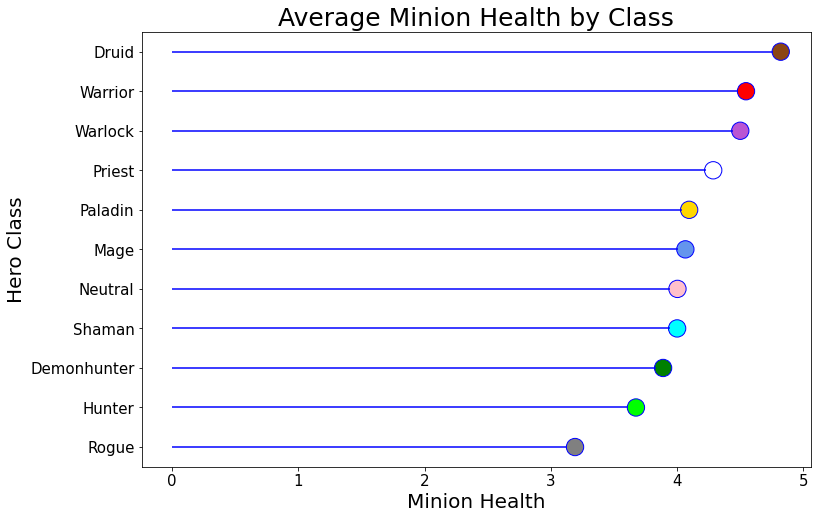

In [47]:
# creating series of average minion health, sorted alphabetically by hero class name
minions_health = minions.groupby('name_prime_hero_class').mean()['health'].sort_values()
minions_health.index = minions_health.index.str.title()

# creating list of colors for hero class colors based on order in minions_health series
health_colors = color_mapper(minions_health.index)

# plotting horizontal lines (stems of lollipops)
ytick_range = range(0,len(minions_health.index))
plt.hlines(y = ytick_range, xmin = 0, xmax = minions_health - .06, color = 'b')

# plotting dots ("candy" portion of lollipop) that reflect average minion health for respective class
plt.scatter(minions_health, ytick_range, color = health_colors , s = 300, edgecolors= 'b')

# configuring ticks, axis labels, etc.
plt.yticks(ytick_range, minions_health.index, fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Hero Class', fontsize = 20)
plt.xlabel('Minion Health', fontsize = 20)
plt.title('Average Minion Health by Class', fontsize = 25)

plt.show()

- The range of the average health between minions of different classes is relatively substantial
    - A minion losing or gaining 1 health as a result of a balancing patch usually has a major impact on their viability


- Rogue minons have the lowest average health among all minions
    - This is consistent with their propensity for being a class that plays cheaper, weaker cards in large volumes to compensate for their lack of individual impact
    
    
- Druid minions have the highest average health among all minions
    - This makes sense given that one of their main strategies is to ramp up resources in order to play more powerful spells and minions so the developers gave them "bulkier" (ie. higher health) creatures on average. 
        - Bulkier creatures are harder to remove, so druid is rewarded for their investment, in part, by having minions that are harder to destroy

## Variable: Attack (Minions)
Attack determines how much damage a minion can output.

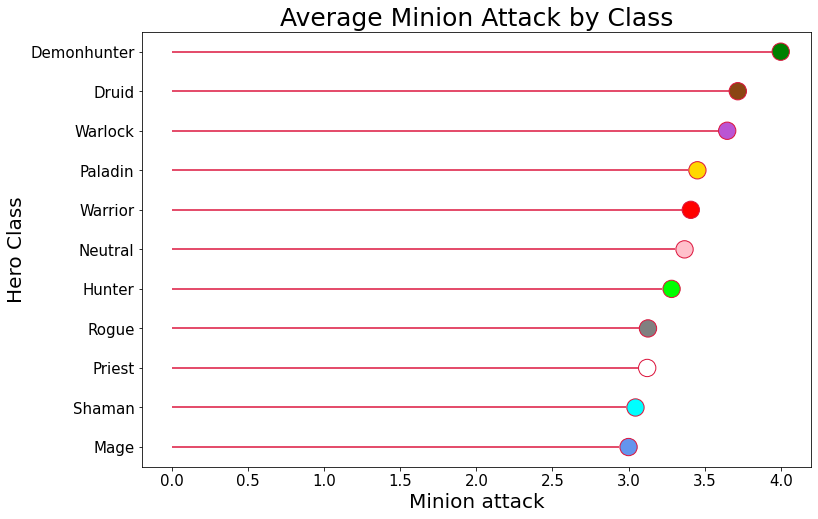

In [48]:
# creating series of average minion attack, sorted alphabetically by hero class name
minions_attack = minions.groupby('name_prime_hero_class').mean()['attack'].sort_values()
minions_attack.index = minions_attack.index.str.title()

# creating list of colors for hero class colors based on order in minions_attack series
attack_colors = color_mapper(minions_attack.index)

# plotting horizontal lines (stems of lollipops)
ytick_range = range(0,len(minions_attack.index))
plt.hlines(y = ytick_range, xmin = 0, xmax = minions_attack - .06, color = 'crimson')

# plotting dots ("candy" portion of lollipop) that reflect average minion attack for respective class
plt.scatter(minions_attack, ytick_range, color = attack_colors, s = 300, edgecolors= 'crimson')

# configuring ticks, axis labels, etc.
plt.yticks(ytick_range, minions_attack.index, fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Hero Class', fontsize = 20)
plt.xlabel('Minion attack', fontsize = 20)
plt.title('Average Minion Attack by Class', fontsize = 25)

plt.show()

- The range of average minion attack values between classes is ~3 - ~4
    - Although the range isn't as large as minion health, it is a significant range nonetheless. Like with minion health, 1 increase or decrease to a minions attack can have a significant impact on its competitive viability
    
    
- The order of the classes has changed from the order in the health plot


- Demon hunter minions have the highest average attack
    - Demon hunters are known to be an agressive class, as opposed to classes like priest which are more defensive by nature.


- Mage minons are nearly tied with shamans for the lowest average attack values
    - I'm surpised by this, I figured that this rank would have been held by one of the more defensive classes such as priest 


## Variables: Attack and Health (Minions)

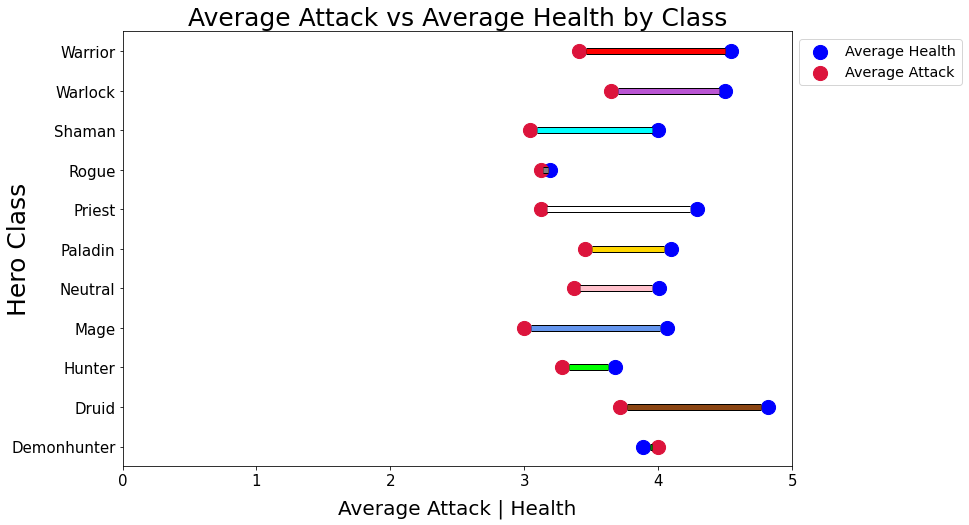

In [126]:
# creating df that holds both average minion attack and health
atk_and_hlth_df = pd.DataFrame(dict(Average_Health = minions_health, Average_Attack = minions_attack))
atk_and_hlth_df.columns = ['Average Health', 'Average Attack']

# creating list of colors for horizontal lines
hlth_attk_colors = color_mapper(atk_and_hlth_df.index)

# setting y tick range
ytick_range = range(0,len(atk_and_hlth_df.index))

# creating xmin and xmax arrays based on which value is higher, average attack or average health
x_min_val = np.where(atk_and_hlth_df['Average Health'] > atk_and_hlth_df['Average Attack'], atk_and_hlth_df['Average Health'] - .05, atk_and_hlth_df['Average Health'] + .05)
x_max_val = np.where(atk_and_hlth_df['Average Health'] > atk_and_hlth_df['Average Attack'], atk_and_hlth_df['Average Attack'] + .05, atk_and_hlth_df['Average Attack'] - .05)

# creating scatter plot points for attack and health
plt.scatter(atk_and_hlth_df['Average Health'], ytick_range, color='b', alpha=1, label='Average Health', s = 200)
plt.scatter(atk_and_hlth_df['Average Attack'], ytick_range, color='crimson', label='Average Attack', s = 200)

# creating horizontal lines to connect attack and health along with black outline
# have to create larger black bar in background since hlines edgecolor argument fills entire line instead of outline
ax = plt.hlines(y = ytick_range, xmin = x_min_val, xmax = x_max_val, colors = 'black', linewidth= 7)
ax = plt.hlines(y = ytick_range, xmin = x_min_val, xmax = x_max_val , colors = hlth_attk_colors, linewidth= 5)
 
# setting xticks, yticks, axis labels, title, and legend
plt.xticks(range(0,6,1), fontsize = 15)
plt.yticks(ytick_range, atk_and_hlth_df.index, fontsize = 15)
plt.title('Average Attack vs Average Health by Class', fontsize = 25)
plt.xlabel('Average Attack | Health', fontsize = 20, labelpad = 10)
plt.ylabel('Hero Class', fontsize = 25, labelpad = -20)
plt.legend(bbox_to_anchor=(1, 1), fontsize='x-large')

plt.show()

- The range of average attack and health varies significantly between some classes


- Warrior, Warlock, Shaman, Priest and Hunter have approximately 1 more health than attack on average


- Paladin, Neutral, and Hunter have approximately .5 more health than attack on average


- Rogue and Demonhunter have almost identical attack and health on average


- Uniquely, demonhunter is the only class with minions that have higher attack than health on average

## Variables: Attack, Health, and Manacost (Minions)

In [50]:
# created series of average minion manacost for each class
minions_manacost = minions.groupby('name_prime_hero_class').mean()['manacost']
minions_manacost.index = minions_manacost.index.str.title()

# creating df for radar plot
radar_df = pd.DataFrame(dict(Average_Mana = minions_manacost, Average_Health = minions_health, Average_Attack = minions_attack))

# resetting index to convert index to column
radar_df.reset_index(inplace=True)

# renaming columns
radar_df.columns = ['Hero Class', 'Average Mana', 'Average Health', 'Average Attack']

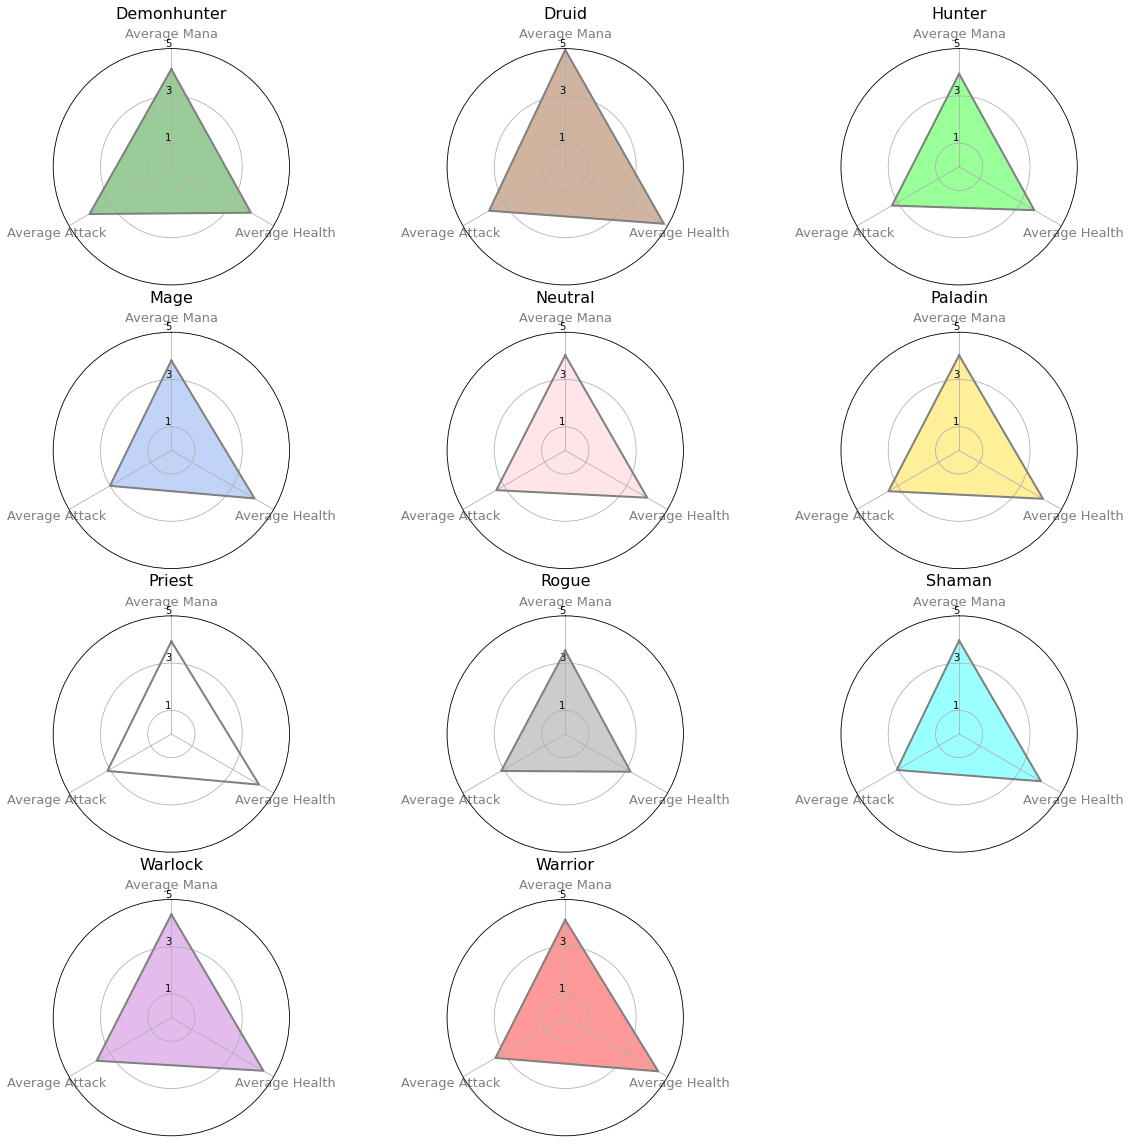

In [51]:
def make_spider(row, subplot_title, subplot_color):

    # number of variables
    categories = list(radar_df)[1:]
    N = len(categories)

    # setting angles of each axis in plot
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # initialising radar plot
    ax = plt.subplot(4, 3, row + 1, polar = True)

    # centering radar (ie. rotating so that one variable is at top)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color = 'grey', size = 13, ha = 'center')

    # setting y tick values and labels
    ax.set_rlabel_position(0)
    plt.yticks([1, 3, 5], ["1", "3" ,"5"], color = "black", size = 10, ha = 'right')
    plt.ylim(0, 5)

    values = radar_df.loc[row].drop('Hero Class').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color = 'grey', linewidth = 2, linestyle='solid')
    ax.fill(angles, values, color = subplot_color, alpha = 0.4)

    # Add a title
    plt.title(subplot_title, size = 16, color = "black", y = 1.1)
    
# setting figure size
plt.figure(figsize=(20, 20))

# creating list of colors for subplots
radar_colors = color_mapper(radar_df['Hero Class'])
 
# using for loop to plot
for row in range(0, len(radar_df.index)):
    make_spider(row, radar_df['Hero Class'][row], radar_colors[row])

- Demonhunter and Rogue look very balanced between thier average minion attack, health and manacost values
- Druid minions have very high average manacost and health compared to their average attack
- All other classes show have very balanced attack and manacost values but higher health values

## Variable: Durability (Weapons)

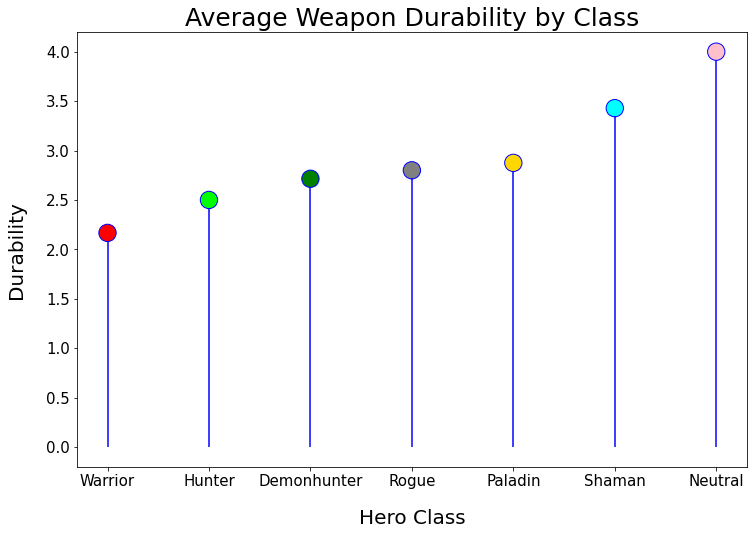

In [52]:
# creating series of average weapon durability, sorted alphabetically by hero class name
weapons_dur = weapons.groupby('name_prime_hero_class').mean()['durability'].sort_values()
weapons_dur.index = weapons_dur.index.str.title()

# creating list of colors for hero class colors
dur_colors = color_mapper(weapons_dur.index)

# plotting horizontal lines (stems of lollipops)
xtick_range = range(0,len(weapons_dur.index))
plt.vlines(x = xtick_range, ymin = 0, ymax = weapons_dur - .08, color = 'b')

# plotting dots ("candy" portion of lollipop) that reflect average weapon durability for respective class
plt.scatter(xtick_range, weapons_dur, color = dur_colors , s = 300, edgecolors= 'b')

# configuring ticks, axis labels, etc.
plt.xticks(xtick_range, weapons_dur.index, fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Hero Class', fontsize = 20, labelpad = 20)
plt.ylabel('Durability', fontsize = 20, labelpad = 20)
plt.title('Average Weapon Durability by Class', fontsize = 25)

plt.show()

- Warrior weapons have the lowest durability on average
- Neutral weapons have the highest durabilitiy on average
- Shaman weapons have the highest durabilitiy on average of all non-neutral classes

## Variable: Attack (Weapons)

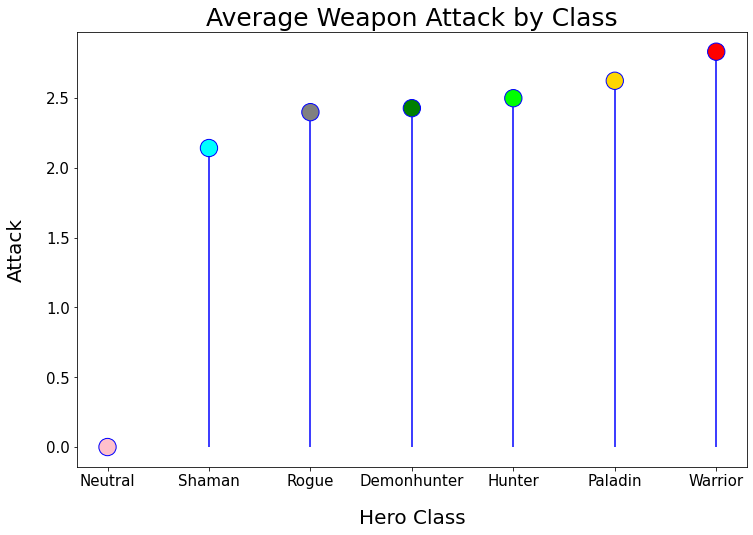

In [53]:
# creating series of average weapon attack, sorted alphabetically by hero class name
weapons_attack = weapons.groupby('name_prime_hero_class').mean()['attack'].sort_values()
weapons_attack.index = weapons_attack.index.str.title()

# creating list of colors for hero class colors
attack_colors = color_mapper(weapons_attack.index)

# creating array of ymax values for lollipop stems
# removing stem if attack of weapon is 0
ymax_set = np.where(weapons_attack > 0, weapons_attack - .06, 0)

# plotting vertical lines (stems of lollipops)
xtick_range = range(0,len(weapons_attack.index))
plt.vlines(x = xtick_range, ymin = 0, ymax = ymax_set, color = 'b')

# plotting dots ("candy" portion of lollipop) that reflect average weapon attack for respective class
plt.scatter(xtick_range, weapons_attack, color = attack_colors , s = 300, edgecolors= 'b')

# configuring ticks, axis labels, etc.
plt.xticks(xtick_range, weapons_attack.index, fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Hero Class', fontsize = 20, labelpad = 20)
plt.ylabel('Attack', fontsize = 20, labelpad = 20)
plt.title('Average Weapon Attack by Class', fontsize = 25)

plt.show()

- Neutral weapons have the lowest average attack, albeit there is only one neutral weapon in the dataset
- Shamans have the lowest average weapon attack among all non-neutral classes
- Warriors have the highest average weapon attack

## Variables: Durability and Attack (Weapons)

In [100]:
atk_and_dur_df

,Average Durability,Average Attack
Demonhunter,2.714286,2.428571
Hunter,2.500000,2.500000
Neutral,4.000000,0.000000
Paladin,2.875000,2.625000
Rogue,2.800000,2.400000
Shaman,3.428571,2.142857
Warrior,2.166667,2.833333


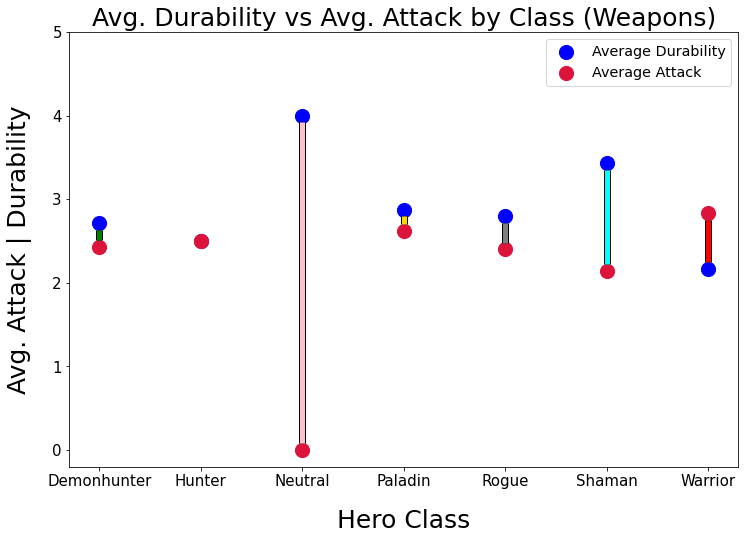

In [132]:
# creating df that holds both average minion attack and health
atk_and_dur_df = pd.DataFrame(dict(Average_Durability = weapons_dur, Average_Attack = weapons_attack))
atk_and_dur_df.columns = ['Average Durability', 'Average Attack']

# creating list of colors for vertical lines
dur_attk_colors = color_mapper(atk_and_dur_df.index)

# setting x tick range
xtick_range = range(0,len(atk_and_dur_df.index))

# creating array of y min and max values for stems based on whether class avg weapon attack or durability is higher
y_min_val = np.where(atk_and_dur_df['Average Durability'] > atk_and_dur_df['Average Attack'], atk_and_dur_df['Average Durability'] - .08, atk_and_dur_df['Average Durability'] + .08)
y_max_val = np.where(atk_and_dur_df['Average Durability'] > atk_and_dur_df['Average Attack'] , atk_and_dur_df['Average Attack'] + .08, atk_and_dur_df['Average Attack'] - .08)

# if class avg weapon attack and durability are equal, remove stem via changing ymin and ymax to 0, otherwise, keep same ymin and ymax values
y_min_val = np.where(atk_and_dur_df['Average Durability'] == atk_and_dur_df['Average Attack'], 0, y_min_val)
y_max_val = np.where(atk_and_dur_df['Average Durability'] == atk_and_dur_df['Average Attack'] , 0, y_max_val)

# creating scatter plot points for attack and durability
plt.scatter(xtick_range, atk_and_dur_df['Average Durability'], color='b', alpha=1, label='Average Durability', s = 200)
plt.scatter(xtick_range, atk_and_dur_df['Average Attack'], color='crimson', label='Average Attack', s = 200)

# creating vertical lines to connect attack and health along with black outline
# have to create larger black bar in background since vlines edgecolor argument fills entire line instead of outline
ax = plt.vlines(x = xtick_range, ymin = y_min_val, ymax = y_max_val, colors = 'black', linewidth= 7)
ax = plt.vlines(x = xtick_range, ymin = y_min_val, ymax = y_max_val , colors = dur_attk_colors, linewidth= 5)

# setting xticks, yticks, axis labels, title, and legend
plt.yticks(range(0,6,1), fontsize = 15)
plt.xticks(xtick_range, atk_and_dur_df.index, fontsize = 15)
plt.title('Avg. Durability vs Avg. Attack by Class (Weapons)', fontsize = 25)
plt.ylabel('Avg. Attack | Durability', fontsize = 25, labelpad = 20)
plt.xlabel('Hero Class', fontsize = 25, labelpad = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize='x-large')

plt.show()

- Neutral class has largest gap between average weapon attack and durability, ableit, there is only one neutral weapon
- Shaman class has the largest gap between average weapon attack and durability out of all non-neutral classes
- Paladin class has the smallest gap between average weapon attack and durability among classes with a difference between these values
- Hunter is the only class that has equal average weapon attack and durability 

## Variable: Minion Type 

In [54]:
# creating df with count of minions per class
circle_data = pd.DataFrame(minions.groupby(['name_prime_hero_class'])['text'].count())

# resetting index
circle_data.reset_index(inplace = True)

In [55]:
# creating empty list
circle_dict_list = []

# adding classes and total minions per class to list
for x in circle_data.name_prime_hero_class:
    circle_dict_list.append({'id' :  x, 'datum' : int(circle_data.loc[circle_data['name_prime_hero_class'] == x, 'text'].values)})


In [56]:
# creating DF of minion tribe counts per class
class_minion_counts = pd.DataFrame(minions.groupby(['name_prime_hero_class', 'name_minion_tribe'])['text'].count())

# adding counts of each minion tribe per class to list
for i in range(len(circle_dict_list)):
    tempd = []
    for ind, t in enumerate(class_minion_counts.index):
        if t[0] == circle_dict_list[i]['id']:
            tempd.append({'id' : t[1], 'datum' : class_minion_counts.text[ind]})
            circle_dict_list[i]['children'] = tempd


In [57]:
# adding overall minion count to list
final = [{'id': 'all', 'datum': 842, 'children' : circle_dict_list}]

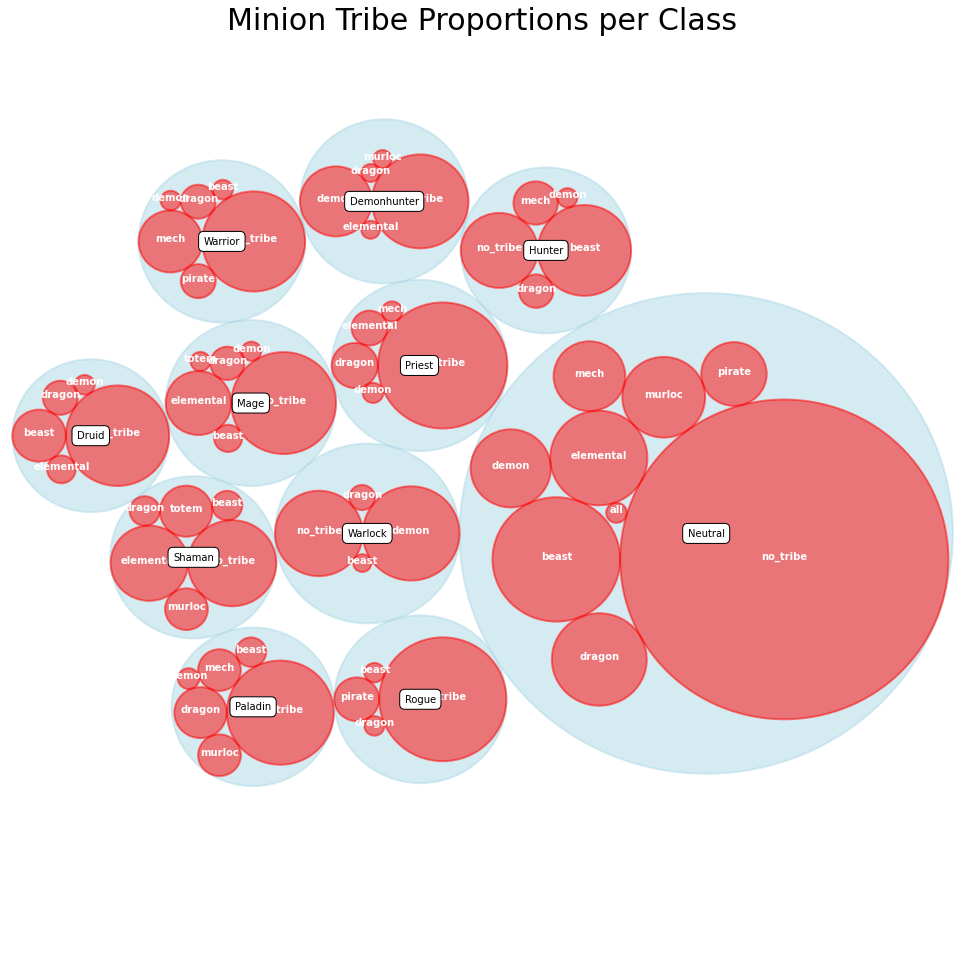

In [58]:
# setting circle positions
circles = circlify.circlify(
    final, 
    show_enclosure = False, 
    target_enclosure = circlify.Circle(x=0, y=0, r=1)
)

# creating figure and subplot
fig, ax = plt.subplots(figsize=(17,17))

# setting title
ax.set_title('Minion Tribe Proportions per Class', fontsize=30)

# removing axis
ax.axis('off')

# capturing axis borders
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# printing circles for classes (blue circles)
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="lightblue"))

# printing circles for minion tribes (green circles)
for circle in circles:
    if circle.level != 3:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color = "red"))
    plt.annotate(label, (x,y ), ha='center', color="white", fontweight = 'bold')

# printing labels for classes
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"].title()
    plt.annotate(label, (x,y ) , va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))


- The blue circles represent the prevalency of each classes' minions within the standard format
    - Neutral has the most minions
    - All other classes have similar amounts
    
- The red circles represent the prevalency of each minion tribe within each class
    - Minions with no tribe are the most or second-most common within all classes
    
    - Besides "no-tribe" minions, these were the most common tribes within each class
        - Beast
            - Druid
            - Hunter
        - Pirate
            - Rogue
        - Dragon
            - Paladin
            - Priest
        - Demon
            - Demonhunter
            - Warlock
        - Elemental
            - Shaman
            - Mage
        - Warrior
            - Mech

## Variable: Multiclass Cards
Multiclass cards are cards that have more than one class.
Note that since there are no multiclass cards that feature the neutral class, the neutral class won't be included in this portion of exploration.

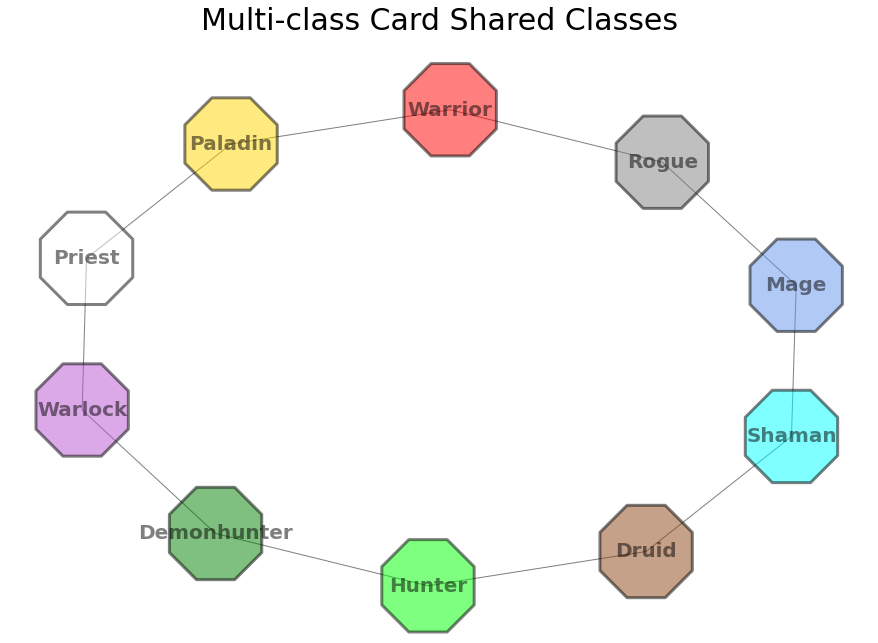

In [59]:
# creating df of only multiclass cards
multiclass_cards = df[df.is_multiclass == 1]

# capitalizing each class name
multiclass_cards.name_prime_hero_class = multiclass_cards.name_prime_hero_class.str.title()
multiclass_cards.name_second_hero_class = multiclass_cards.name_second_hero_class.str.title()

# specifying dataframe and columns for node values
G = nx.from_pandas_edgelist(multiclass_cards, 'name_prime_hero_class', 'name_second_hero_class')

# creating list of colors for nodes
node_class_list = [node.title() for node in G]
node_color_list = color_mapper(node_class_list)
 
# plotting network graph
nx.draw(G, 
        with_labels=True, 
        figsize=(10,10), 
        node_size= 10000, 
        node_color = node_color_list, 
        node_shape="8", 
        alpha=0.5, 
        linewidths = 3, 
        edgecolors = 'black', 
        font_size = 20, 
        font_weight = 'bold', 
        font_color="black")
axis = plt.gca()

# setting x and y limits to prevent cutoff of nodes
axis.set_xlim([1.1*x for x in axis.get_xlim()])
axis.set_ylim([1.1*y for y in axis.get_ylim()])

# setting title
plt.title('Multi-class Card Shared Classes', fontsize = 30, pad = 30)
plt.show()

- Every class has a multiclass card with 2 other classes and when mapped, form a loop


- Some relationships seem apparent
    - Druid, Shaman
        - Draw their powers from nature (druids from animals, shamans from elements)
    - Shaman, Mage
        - Both use water, ice, and fire in combat
    - Warrior, Paladin
        - Both use heavy armor and big powerful weapons
    - Paladin, Priest
        - Both use "the light" as the source of their power
    - Hunter, Druid
        - Both are very connected animals (druids transform into animals while hunters tame animals)
    - Priest, Warlock
        - Some priests can call upon the "void" or "shadow energy" which are power sources that warlocks frequently tap into
        
        
- Other relationships seem forced
    - Mage, Rogue
        - Mages and rogues don't have any notable similarities from a lore perspective
            - Mages use ice, fire, arcane energy and wear robes
            - Rogues use stealth, swiftness, daggers (typically) and wear light armor
    - Rogue, Warrior
        - These classes can be seen as direct opposites in many ways
            - Warriors are brash and loud, rogues are stealthy and subtle
            - Warriors typically use large weapons and heavy armor while rogues use light armor and daggers
    - Demonhunter, hunter
        - Despite their names, these classes don't have any notable similarities from a lore perspective
            - Demonhunters draw their power from demonic entities
            - Hunters use animals that are typically found in nature

In [60]:
# creating dictionary of monoclass card counts per class
venn_dict_monoclasses = {}
for x in classes.name:
    if x != 'neutral':
        venn_dict_monoclasses[x.title() + "_cards"] = df[(df["is_" + x] == 1) & (df.is_multiclass == 0)].shape[0]

# creating nested list that contains each multiclass card class pairs (example. warrior/paladin, priest/warlock, etc)
multiclass_pairs = nx.to_pandas_edgelist(G).values.tolist()

# creating dictionary of each class pair and the number of multiclass cards that contain their unique pairing
venn_dict_multiclasses = {}
for x in multiclass_pairs:
    venn_dict_multiclasses[x[0]+x[1]] = df[(df.name_prime_hero_class.str.title() == x[0]) & (df.name_second_hero_class.str.title() == x[1])].shape[0]

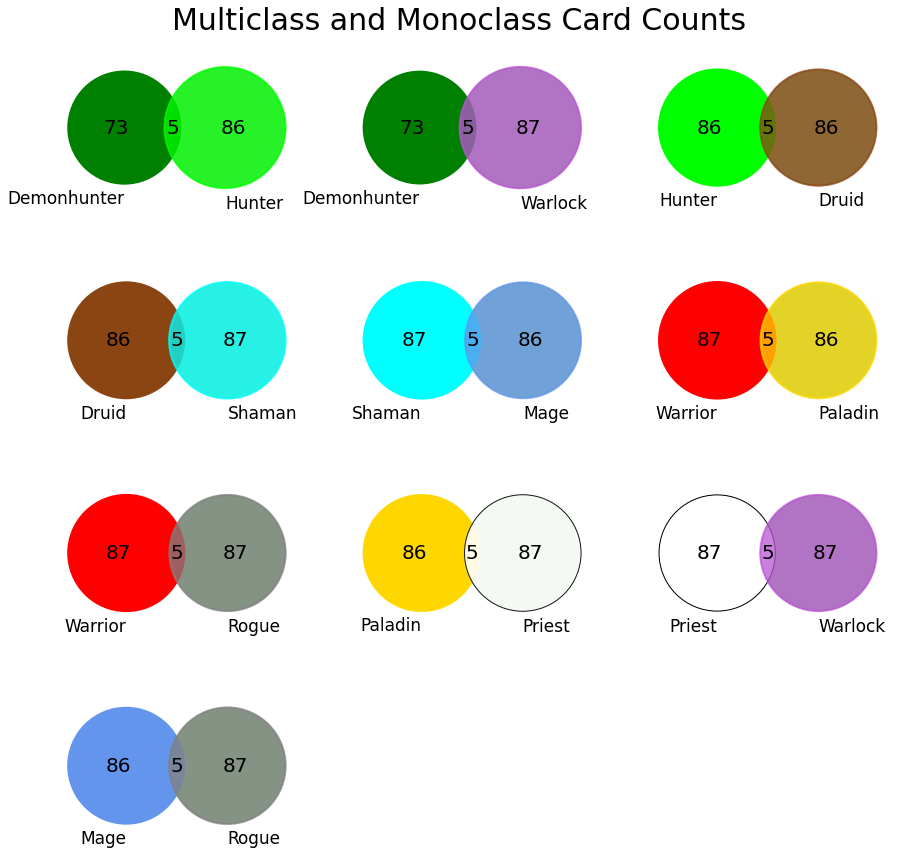

In [61]:
# setting shape for overall subplot shape
row_count = 4
col_count = 3

# setting figure size
fig = plt.figure(figsize=(15,15))
fig.suptitle('Multiclass and Monoclass Card Counts', fontsize = 30, y = .91)
subplot_counter = 0

# creating venn subplots
for x in multiclass_pairs:
    subplot_counter += 1
    plt.subplot(row_count, col_count, subplot_counter)
    v = venn2(subsets = (venn_dict_monoclasses[x[0] + '_cards'], 
                         venn_dict_monoclasses[x[1] + '_cards'], 
                         venn_dict_multiclasses[x[0]+x[1]]), 
                          set_labels = (x[0], x[1]))
    # setting font sizes for text
    for text in v.set_labels:
        text.set_fontsize(17)
    for text in v.subset_labels:
        text.set_fontsize(20)
    # getting circles data to adjust colors, alpha, etc. in section below
    c = venn2_circles(subsets = (venn_dict_monoclasses[x[0] + '_cards'], 
                                 venn_dict_monoclasses[x[1] + '_cards'], 
                                 venn_dict_multiclasses[x[0]+x[1]]))
    # setting colors and alpha for each circle 
    first_circle_color = colord[x[0]]
    second_circle_color = colord[x[1]]
    c[0].set_color(first_circle_color)
    c[1].set_color(second_circle_color)
    c[1].set_alpha(.75)
    # adding outline and adjusting alpha for the priest class 
    # since the previous settings would make its color appear strangely 
    if x[0] == 'Priest':
        c[0].set_edgecolor("black")
        c[0].set_lw(1)
    if x[1] == 'Priest':
        c[1].set_edgecolor("black")
        c[1].set_alpha(.90)
        c[1].set_lw(1)

plt.show()

- All non-neutral, non-demon hunter classes have 86 or 87 mono class cards
    - Demon hunters were added to the game after all of the other classes so they will need at least one additional expansion before their card counts increase to the norm


- Each dual class pair have exactly 5 cards between them

## Variable: Keywords
Keywords are special mechanics that have different effects. For example, a minion with the keyword, "rush", can attack other minions immediately upon entering the field, while other minions must wait a turn.

In [62]:
# creating empty dictionary
keyword_dict = {}

# adding each class name to dictionary as keys
# values for each class (key), are the respective classes' keyword counts
for classname in classes.name:
    class_cards = df[df.name_prime_hero_class == classname]
    keyword_dict[classname] = pd.Series(' '.join(class_cards.allkws).split()).value_counts()

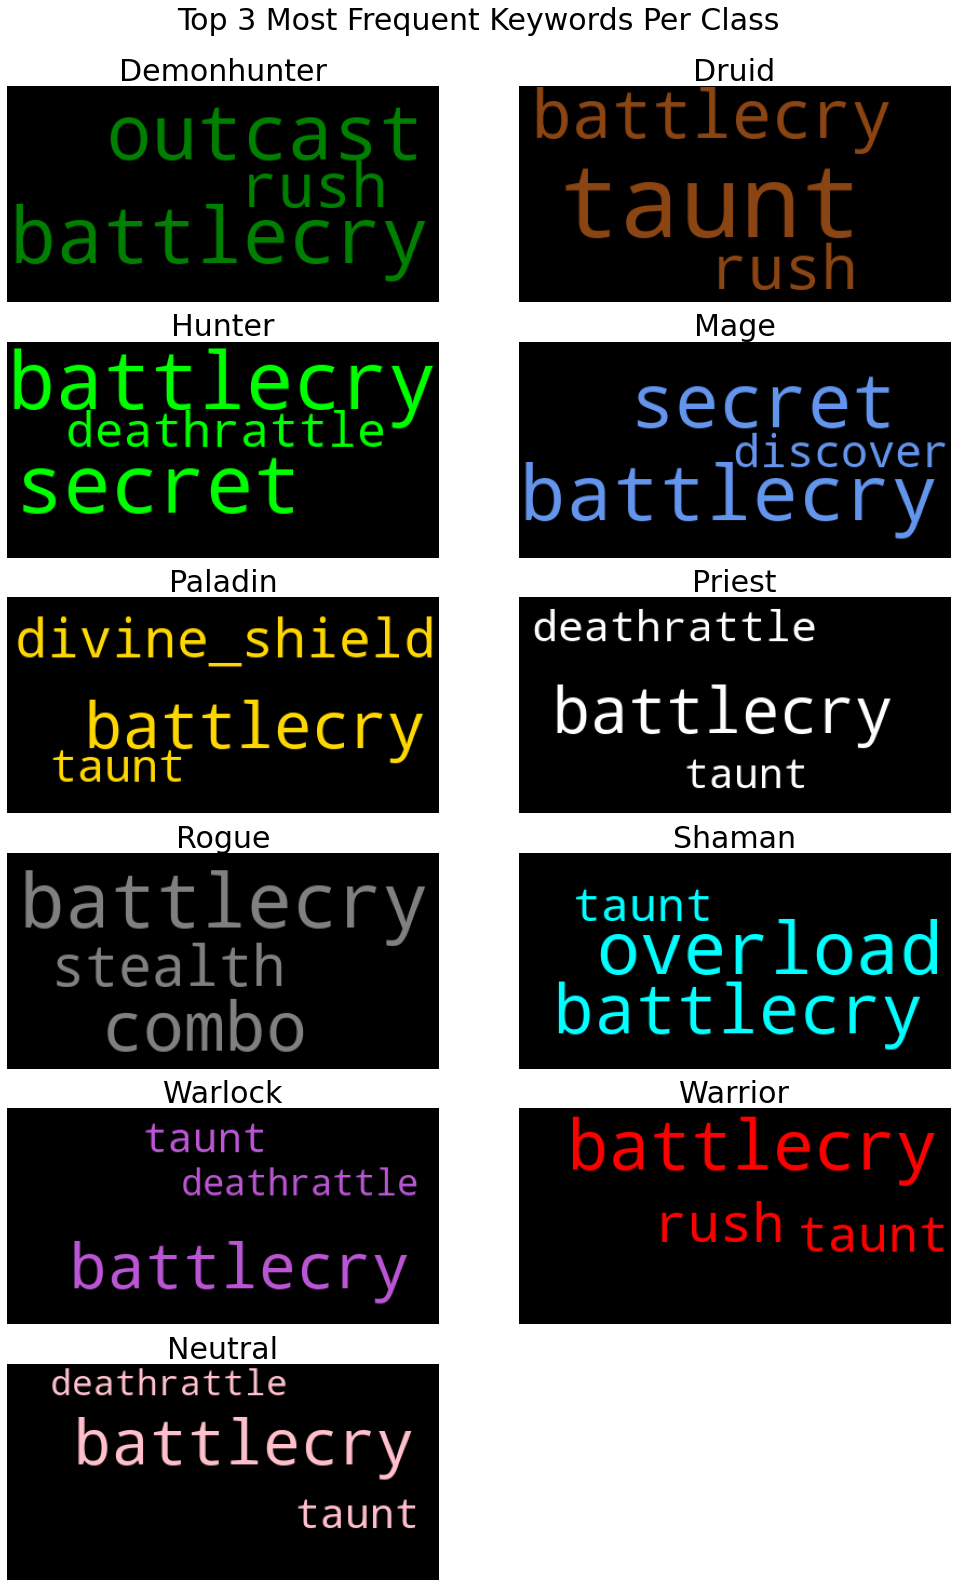

In [63]:
# setting shape for overall subplot shape
row_count = 6
col_count = 2

# setting figure size
fig = plt.figure(figsize=(15,22))
fig.suptitle('Top 3 Most Frequent Keywords Per Class', fontsize = 30, y = 1)
subplot_counter = 0

# creating wordcloud for each classes' keywords
for k in keyword_dict:
    subplot_counter += 1
    plt.subplot(row_count, col_count, subplot_counter)
    wordcloud = WordCloud(max_words = 3, color_func=lambda *args, **kwargs: colord[k.title()]).generate_from_frequencies(keyword_dict[k])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.title(k.title(), fontsize = 30)

plt.show()

- Battlecry is in the top 3 most frequent keywords of each class


- Demonhunter
    - Battlecry is the most common keyword
    - Outcast and rush appear to roughly equally as common
    - Outcast is a keyword that is unique to demonhunter


- Druid
    - Taunt is the most common keyword
    - Rush and battlecry appear to near eachother in frequency


- Hunter
    - Battlecry and secret are close to one another and the most frequent keywords
    - Deathrattle is the 3 most common keyword


- Mage
    - Battlecry is the most common keyword
    - Discover and secret appear to have similar frequency rates


- Paladin
    - Battlecry is the most common keyword
    - Divine shield is the second most common keyword
    - Taunt is the third most common keyword


- Priest
    - Battlecry is the most common keyword
    - Deathrattle and taunt are close to each other in frequency


- Rogue
    - Battlecry is the most common keyword
    - Stealth and combo appear to have similar frequency rates


- Shaman
    - Overload appears to be the most common keyword 
    - Battlecry is the second most common keyword and is only slightly less frequent than overload
    - Windfury is the third most common keyword


- Warlock
    - Battlecry is the most common keyword
    - Taunt and deathrattle are notably less frequent than battlecry


- Warrior
    - Battlecry is the most common keyword
    - Rush appears to be slightly more common than taunt
    - Taunt appears to be the third most common keyword


- Neutral
    - Battlecry is the most common keyword
    - Taunt and deathrattle are notably less frequent than battlecry and have similar frequency rates


## Variable: Text

In [64]:
# using regex to remove keywords and their surround <b> </b> tags
# since they were covered in another section
df['filtered_text'] = df.text.str.replace("<b>[^>]*</b>", "")

# using regex to remove any characters that arent letters, numbers, single quotes, or spaces along with 'nbsp' 
df['filtered_text'] = df.filtered_text.str.replace("[^0-9a-zA-Z ']+", "")   
df['filtered_text'] = df.filtered_text.str.replace("nbsp", "")   

# tokenizing and lemmatizing text
tokenizer = nltk.tokenize.ToktokTokenizer()
df.filterd_text = tokenizer.tokenize(df.filtered_text, return_str=True)

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['filtered_text'] = df.filtered_text.apply(lemmatize_text)
df['filtered_text'] = df.filtered_text.apply(lambda x: ' '.join([str(i) for i in x]))

In [65]:
# creating list of stopwords
stopword_list = stopwords.words('english')

# removing stopwords from text
def remove_stop_words(text):
    return [w for w in text.split() if w not in stopword_list]

df['filtered_text'] = df.filtered_text.apply(remove_stop_words)
df['filtered_text'] = df.filtered_text.apply(lambda x: ' '.join([str(i) for i in x]))

In [66]:
# creating empty dictionary
bigram_dict = {}

# adding each class name to dictionary as keys
# values for each class (key), are the respective classes' filtered text
for classname in classes.name:
    class_cards = df[df.name_prime_hero_class == classname]
    joined_text = pd.Series(' '.join(class_cards.filtered_text).split())
    bigram_dict[classname] = (pd.Series(nltk.ngrams(joined_text, 2)).value_counts().head(3))

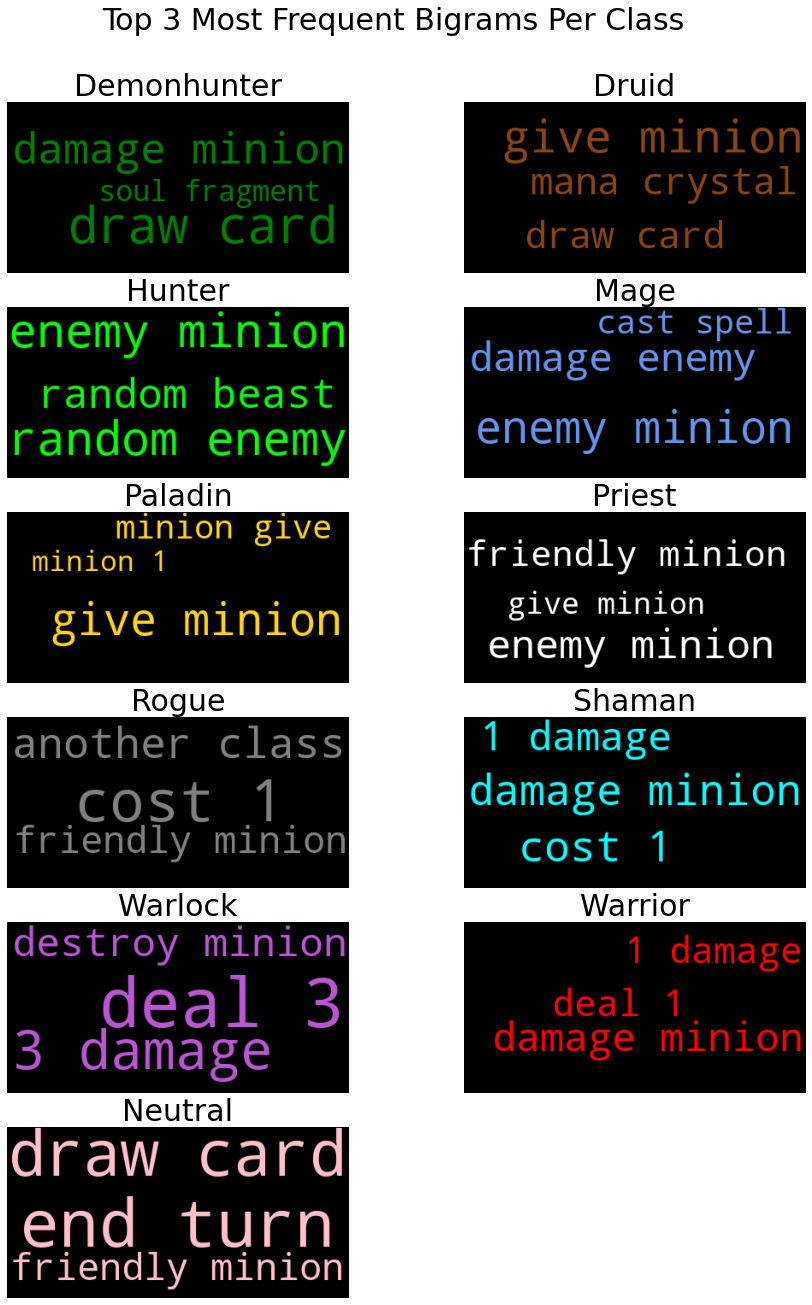

In [67]:
# setting shape for overall subplot shape
row_count = 6
col_count = 2

# creating wordclouds
fig = plt.figure(figsize=(15,22))
fig.suptitle('Top 3 Most Frequent Bigrams Per Class', fontsize = 30, y = .94)
subplot_counter = 0

for k in bigram_dict:
    subplot_counter += 1
    plt.subplot(row_count, col_count, subplot_counter)
    data = {k[0] + ' ' + k[1]: v for k, v in bigram_dict[k].to_dict().items()}
    img = WordCloud(color_func=lambda *args, **kwargs: colord[k.title()]).generate_from_frequencies(data)
    plt.title(k.title(), fontsize = 30)
    plt.imshow(img)
    plt.axis('off')

plt.show()

- Demonhunter
    - Drawing cards appears to be the most common effect ('draw card')
    - Damaging minions ('damage minion) and giving hero attack power ('give hero')

- Druid
    - Minion updgrades appear to be the most common effect ('give minion')
    - Mana crystal ('mana crystal') and card draw (draw card) have similar rates of appearance 


- Hunter
    - Effects that target enemies ('random enemy', 'enemy minion) are the most common
    - Effects that deal with random beasts ('random beast) appear to be the third most common


- Mage
    - Effects that target enemy minions ('enemy minion')
    - Effects that damage enemies ('damage enemy') and involve spells casts ('cast spell') are the next most common


- Paladin
    - Effects that empower minions ('give minion', 'minion give', 'minion 1') are the most common


- Priest
    - Effects that target enemy minions ('enemy minion') are the most common
    - Effects that target friendly minions ('friendly minion', 'give minion') are the second and third most common, respectively


- Rogue
    - Effects that involve 1-cost cards and/or reducing cards to 1 mana cost ('cost 1') are the most common
    - Cards that involve using cards from other classes ('another class') and targeting enemy minions ('enemy minion')


- Shaman
    - Effects that involve 1-cost cards and/or reducing cards to 1 mana cost ('cost 1') are the most common
    - Effects that damage minions ('damage minion') and/or deal 1 damage ('deal 1') are the next most common


- Warlock
    - Effects that deal 3 damage ('3 damage', 'deal 3') are the most common
    - Effects that affect friendly minions ('friendly minion') are the third most common 


- Warrior
    - Effects that deal damage ('1 damage', 'deal 1', 'damage minion') are the most common


- Neutral
    - Effects that draw cards ('draw card') and happen at the end of player's turns ('end turn') are the most common 
    - Effects that affect friendly minions('friendly minion') are the third most common

## Variable: Childids
Child Ids are cards or semi-permanent effects that are generated by a card. If a card creates new cards, has multiple effects that can be chosen from, or adds a new static image to the board (besides its own art), it has a child id.

In [68]:
# creating series of each classes' average child id count
df.groupby('name_prime_hero_class').mean()['childid_count']

name_prime_hero_class
demonhunter    0.337349
druid          0.822917
hunter         0.364583
mage           0.291667
neutral        0.390181
paladin        0.395833
priest         0.309278
rogue          0.474227
shaman         0.536082
warlock        0.814433
warrior        0.628866
Name: childid_count, dtype: float64

In [69]:
# creating series of each classes' average child id count for all cards with more than 0 child ids
only_childid_cards = df[df.has_child_ids == 1]
only_childid_cards.groupby('name_prime_hero_class').mean()['childid_count']

name_prime_hero_class
demonhunter    2.250000
druid          2.590909
hunter         2.833333
mage           9.000000
neutral        6.133333
paladin        4.000000
priest         7.333333
rogue          6.400000
shaman         6.333333
warlock        6.100000
warrior        6.571429
Name: childid_count, dtype: float64

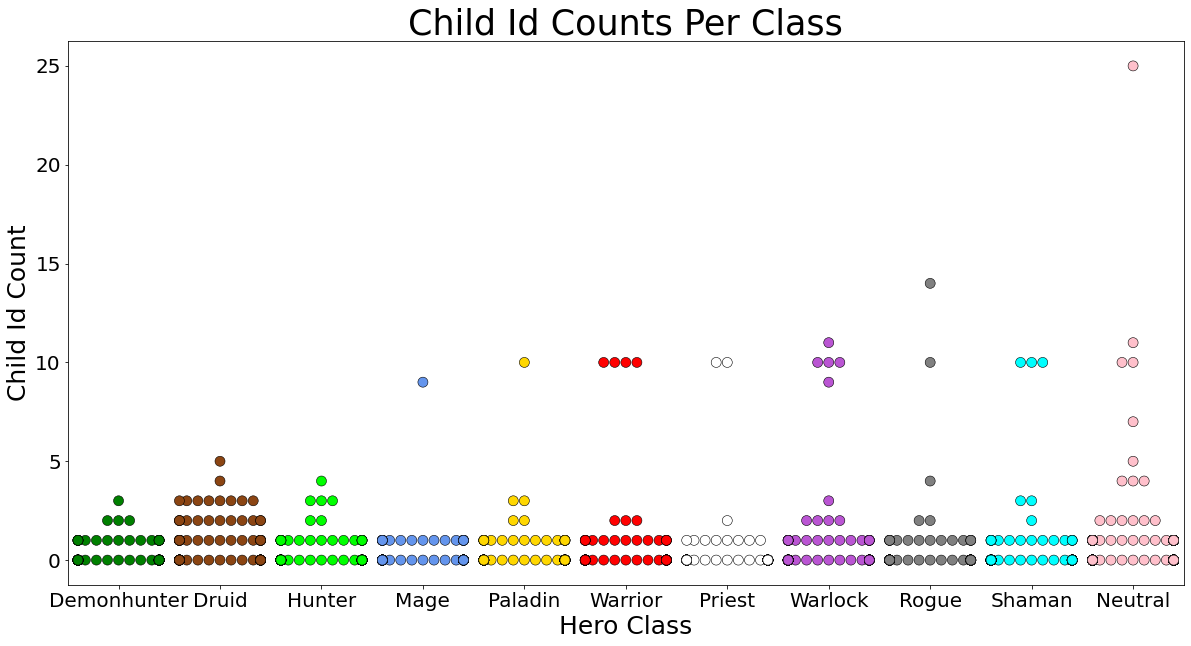

In [70]:
# creating swarmplot
plt.figure(figsize = (20,10)) 
sns.swarmplot(x = df.name_prime_hero_class.str.title(), 
              y = "childid_count", 
              data = df, 
              palette = colord, 
              edgecolor = 'black',
              linewidth = .55,
              size = 10)
plt.title('Child Id Counts Per Class', fontsize = 35)
plt.xlabel('Hero Class', fontsize = 25)
plt.ylabel('Child Id Count', fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

- A majority of all cards in every classe have 0 - 1 child ids

- All Demonhunter, Druid, and Hunter cards have 5 or less child ids

- Mage, Paladin, Warrior, Priest, Warlock, Rogue, Shaman, and Neutral all have 1 - 5 cards with 8 - 15 child ids

- Neutral is the only class with a card that has over 15 child ids, albeit it only has 1 with this property

# Conclusion
***

After exploring the data I've made the following observations that relate to the identities of each hero class. 


__Demonhunter__
- Only class besides neutral with more minions than spells
- Highest average manacost weapons
- Highest average minion attack on average
- Only class with higher attack than health on average 
- One of two classes with notably small gap between average minion health and attack (other is rogue)
- One of two classes with very balanced average attack, health, and manacost among minions (other is rogue)
- "Demon" is most common minion tribe (outside of no_tribe)
- Only class with "outcast" keyword (outside of multiclass cards)
- Least amount of childids overall
- Shares multiclass cards with hunter and warlock

__Druid__
- One of only two classes with more spells than minions (other is warlock)
- Highest average manacost cards among all non-neutral classes
- Highest average manacost minions
- Highest average minion health
- Minions have very high health and manacost compared to attack
- One of three classes where "Beast" is most common minion tribe besides "no_tribe" (others are neutral and hunter)
- Only class with taunt as most common keyword
- Shares multiclass cards with shaman and hunter

__Hunter__
- One of three classes where "Beast" is most common minion tribe besides "no_tribe" (others are neutral and druid)
- Only class with both "secret" and "death rattle" in top 3 keywords
- Shares multiclass cards with druid and demon hunter

__Mage__ 
- Lowest minion attack on average
- One of two classes where "Elemental" is most common minion tribe outside of no_tribe (other is shaman)
- Only class with "discover" in top 3 keywords
- Shares multiclass cards with shaman and rogue


__Neutral__
- Has no spells
- Only class besides demonhunter with more minions than spells
- Highest manacost cards on average for all card types combined
- Lowest average weapon manacost
- Ratio of no_tribe to any other individual minion tribe is much more unbalanced than other classes
- One of three classes where "Beast" is most common minion tribe besides "no_tribe" (others are Druid and Hunter)
- Has most child ids overall


__Paladin__
- Most words on average in card names
- One of two classes where "Dragon" is most common minion tribe outside of no_tribe (other is priest)
- Only class with "divine shield" in top 3 keywords
- Shares multiclass cards with priest and warrior


__Priest__
- One of two classes where "Dragon" is most common minion tribe outside of no_tribe (other is paladin)
- Shares multiclass cards with paladin and warlock

__Rogue__
- Lowest average manacost minions 
- Lowest average manacost spells 
- Lowest average manacost cards overall
- Lowest average word count in card names
- Lowest average minion health
- One of two classes with notably small gap between average minion health and attack (other is demonhunter)
- One of two classes with very balanced average attack, health, and manacost among minions (other is demonhunter)
- "Pirate" is most common minion tribe (outside of no_tribe)
- Only class with "combo" keyword (outside of multiclass cards)
- Only class with "combo" in top 3 keywords
- Only class with "stealth" in top 3 keywords
- Shares multiclass cards with warrior and mage


__Shaman__
- One of two classes where "Elemental" is most common minion tribe outside of no_tribe (other is mage)
- Only class with "overload" keyword (outside of multiclass cards)


__Warlock__
- One of only two classes with more spells than minions (other is druid)
- "Demon" is most common minion tribe
- Only class to have a tribal minion type (demon) outnumber no_tribe minions
- Shares multiclass cards with priest and demonhunter


__Warrior__
- Lowest average manacost weapons
- Largest gap between average minion health and attack 
- "Mech" is most common minion tribe (outside of no_tribe)
- Shares multiclass cards with paladin and rogue


Note that some classes such as Priest, Hunter, and Shaman have almost no identified unique or uncommon traits. Further exploration may yield more findings for these, and other classes like them. 